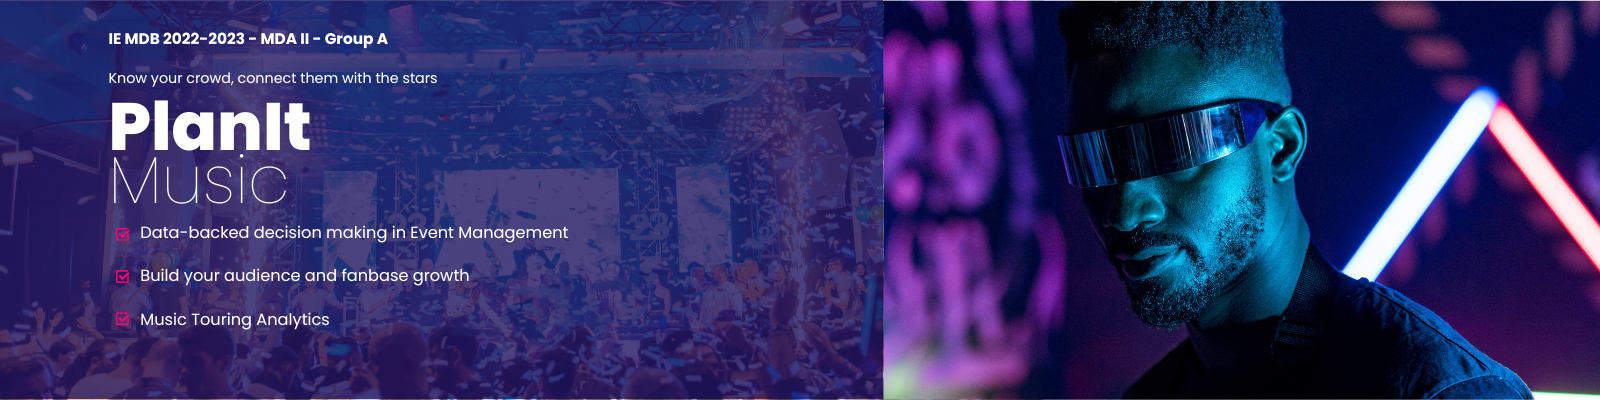

# Table of Content
* [0. Goal Overview for PlanIt Project ](#0)
* [1. Setup](#1)
  * [1.1 Create SparkSession](#1.1)  
  * [1.2 Import data for data analysis](#1.2)
* [2. Answering Business Questions - Goal 1](#2)
  * [2.1 Goal 1: Understanding our Featured ( Main) Artists](#2.1)
  * [2.2 Goal 2: Spotify vs. Twitter Popularity](#2.2)
  * [2.3 Goal 3: Understanding related artist aligned to our feature artist The Weeknd](#2.3)
  * [2.4 Goal 4: What is our reccommendation of a song's lineup?](#2.4) 
  * [2.5 Goal 5: Artist Feature Collaboration Network Beyond Related Artist List Using Graphframes](#2.5) 
* [3. Storing Results in MariaDB](#3)
* [4. Supplementary Analysis - Historical song information last 20 year](#4)

<a id='0'></a>
# 0. Goal overview for PlanIt Project

It is our new project to organize the "Maria-Molina" festival in Los Angeles. Therefore we are keen to analyse the Music Taste of our audience and identity aritists and songs for our festival. We are looking at two categories of artists: The featured artists(main acts) and opening artists). 

Outcome we already shortlisted the artists that we are interested in being our featured artists:
    
o Harry Styles

o Bad Bunny 

o One Republic

o John Legend

o The Weeknd

Overview Business question we want to address:
    
    
1. Goal 1: What ranking these 5 Featured artists are based on number of songs on top charts and how many songs our featured artists have had in the top charts in 2022?

3. Goal 2: is main artist importance/popularity in Spotify aligned to twitter trends?
    
2. Goal 3: Understand which of related artist to the Featured 5 artist should play as opening bands. (ONLY FOR THE WEEKND and the     Related artists associated to THE WEEKND)
    
3. Goal 4: What is our reccommendation of a song's lineup?

4. Goal 4: Provide additional recommendation on which otehr singers our main artists should be collaborating with, on top to the original related artist reccomendations comming from Spotify

<a id='1'></a>
# 1. Setup

In order to analyse our business question in detail we are loading datasets that were ingested through Nifi (either Twitter or Spotify API)

We upload the following data: 
    
    1) The top 10 tracks for 5 main artist ingested through Nifi and saved in HDFS
    2) The  Spotify Top Charts Songs - 2022 from Kaggle
    3) Load Spotify Related Artist Data for 5 Main Artist ingested through Nifi and saved in HDFS 
    4) Load Twitter Data for 5 Main Artist ingested through Nifi and saved in HDFS
    5) Load All Artist Consolidate Tweet for Month per Day

<a id='1.1'></a>
## 1.1 Create SparkSession

In [1]:
import findspark
findspark.init()

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [3]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "graphframes:graphframes:0.8.2-spark3.2-s_2.12" --jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar pyspark-shell'

In [4]:
# import os
# os.environ['PYSPARK_SUBMIT_ARGS'] =  '--jars /usr/share/java/mariadb-java-client.jar pyspark-shell'

In [5]:
print(os.environ)

environ({'LANG': 'en_US.UTF-8', 'LANGUAGE': 'en_US:en', 'PATH': '/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin', 'HOME': '/home/osbdet', 'LOGNAME': 'osbdet', 'USER': 'osbdet', 'SHELL': '/bin/bash', 'INVOCATION_ID': 'd17435fe850d4b4e91d33a238926063d', 'JOURNAL_STREAM': '8:11657', 'SPARK_HOME': '/opt/spark3', 'PYDEVD_USE_FRAME_EVAL': 'NO', 'JPY_PARENT_PID': '369', 'TERM': 'xterm-color', 'CLICOLOR': '1', 'PAGER': 'cat', 'GIT_PAGER': 'cat', 'MPLBACKEND': 'module://matplotlib_inline.backend_inline', 'PYSPARK_PYTHON': '/usr/bin/python3', 'PYSPARK_SUBMIT_ARGS': '--packages "graphframes:graphframes:0.8.2-spark3.2-s_2.12" --jars /opt/hive3/lib/hive-hcatalog-core-3.1.2.jar pyspark-shell'})


In [6]:
from pyspark.sql.session import SparkSession

spark = (SparkSession.builder
    .appName("Spotify_Twitter")
    .getOrCreate())

:: loading settings :: url = jar:file:/opt/spark3/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/osbdet/.ivy2/cache
The jars for the packages stored in: /home/osbdet/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d5d245ac-6858-4dd5-b248-78a5e6f31052;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 204ms :: artifacts dl 19ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	--------------------------------

<a id='1.2'></a>
##  1.2 Import data for data analysis

We load the aggregated information of our five featured artist considering their images, followers the popularity, the artist name, genre and unique id. 

The information was retrieved through Nifi from the following API: Get Artist

In [7]:
from  pyspark.sql.functions import *

# DataFrame creation
main_artist_df = spark.read.option("header","true").csv("hdfs://localhost:9000//datalake/raw/spotify/get_artist")

In [8]:
main_artist_df.show()

+--------------------+---------+----------+------------+--------------------+--------------------+
|              images|followers|popularity|        name|               genre|           artist_id|
+--------------------+---------+----------+------------+--------------------+--------------------+
|https://i.scdn.co...| 51405766|        94|  The Weeknd|canadian contempo...|1Xyo4u8uXC1ZmMpat...|
|https://i.scdn.co...| 23987672|        90|Harry Styles|                 pop|6KImCVD70vtIoJWnq...|
|https://i.scdn.co...| 57945768|        99|   Bad Bunny|           reggaeton|4q3ewBCX7sLwd24eu...|
|https://i.scdn.co...| 14400245|        85| OneRepublic|          piano rock|5Pwc4xIPtQLFEnJri...|
|https://i.scdn.co...|  6291069|        77| John Legend|          neo mellow|5y2Xq6xcjJb2jVM54...|
+--------------------+---------+----------+------------+--------------------+--------------------+



In [9]:
# Create a Main Artist Dict
main_artist_dict = {"OneRepublic":"5Pwc4xIPtQLFEnJriah9YJ", "Harry Styles":"6KImCVD70vtIoJWnq6nGn3", "The Weeknd":"1Xyo4u8uXC1ZmMpatF05PJ", "John Legend":"5y2Xq6xcjJb2jVM54GHK3t" ,"Bad Bunny":"4q3ewBCX7sLwd24euuV69X"}

### Load Spotify Top 10 Tracks  for 5 Main Artists Data

In [10]:
top_tracks_main_artist = spark.read.option("header","true").csv("hdfs://localhost:9000//datalake/raw/spotify/get_top_tracks/*")

In [11]:
top_tracks_main_artist.show()

+-----------+------------+--------------------+--------------------+---------------+--------------------+--------------------+
|duration_ms|release_date|          artists_id|                name|   artists_name|                  id|           artist_id|
+-----------+------------+--------------------+--------------------+---------------+--------------------+--------------------+
|     269560|  2013-08-30|5y2Xq6xcjJb2jVM54...|           All of Me|    John Legend|3U4isOIWM3VvDubwS...|5y2Xq6xcjJb2jVM54...|
|     501648|  2022-08-26|0QHgL1lAIqAw0HtD7...|GOD DID (feat. Ri...|      DJ Khaled|2sOj9vyd6yiss9W1I...|5y2Xq6xcjJb2jVM54...|
|     168562|  2022-09-09|5y2Xq6xcjJb2jVM54...|        Wonder Woman|    John Legend|3BLWGYOcy1svvsBBy...|5y2Xq6xcjJb2jVM54...|
|     190605|  2022-05-19|5NhgsV7qPWHZqYEMK...|          Minefields|        Faouzia|0vH52Icuf6LzOFrkH...|5y2Xq6xcjJb2jVM54...|
|     188046|  2022-09-09|5y2Xq6xcjJb2jVM54...|             Nervous|    John Legend|1XNAH3h63O1hWFcgy...|5y2Xq6

### Load Spotify Top Charts Songs - 2022 

In the top charts of 2022, we analyse each artist, how long they are in the charts and the audio features of the song they have in the charts. 

In [12]:
spotify_top_charts_22 = (spark.read
            .option("header","true")
            .option("inferSchema","true")
            .csv("spotify_top_charts_22.csv")            
            .distinct())

In [13]:
spotify_top_charts_22.show()
spotify_top_charts_22.printSchema()

+--------------------+--------------------+--------------------+---------+--------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+--------------+-----------+
|                 uri|        artist_names|          track_name|peak_rank|weeks_on_chart|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|  tempo|time_signature|duration_ms|
+--------------------+--------------------+--------------------+---------+--------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+--------------+-----------+
|spotify:track:4zN...|James Hype, Miggy...|             Ferrari|       36|            10|       0.847|  0.69|  1|  -7.877|   0|     0.0493|      0.0127|          6.0E-5|  0.0526|125.004|             4|     186662|
|spotify:track:1E5...|          The Weeknd|        Best Friends|       26|             2|       0.737| 0.564|  4|  -7.045|   0|      0.105|     

### Load Spotify Related Artist Data for 5 Main Artist

In [14]:
related_artist_main_artist = spark.read.option("header","true").csv("hdfs://localhost:9000//datalake/raw/spotify/get_related_artist/*")

In [15]:
related_artist_main_artist.show()

+--------------------+---------+----------+-----------------+----------------+--------------------+--------------------+
|              images|followers|popularity|             name|           genre|                  id|           artist_id|
+--------------------+---------+----------+-----------------+----------------+--------------------+--------------------+
|https://i.scdn.co...|  1892473|        63|     Robin Thicke|contemporary r&b|0ZrpamOxcZybMHGg1...|5y2Xq6xcjJb2jVM54...|
|https://i.scdn.co...|  1411870|        59| Anthony Hamilton|contemporary r&b|2DzRMyWgjuMbYvt5B...|5y2Xq6xcjJb2jVM54...|
|https://i.scdn.co...|  1531634|        58|          Maxwell|contemporary r&b|2AOt5htsbtyaHd5Eq...|5y2Xq6xcjJb2jVM54...|
|https://i.scdn.co...|  1796917|        64| Jazmine Sullivan| alternative r&b|7gSjFKpVmDgC2MMsn...|5y2Xq6xcjJb2jVM54...|
|https://i.scdn.co...|  1600813|        57|       Jill Scott|            funk|6AVLthptCPhfrxlHa...|5y2Xq6xcjJb2jVM54...|
|https://i.scdn.co...|  1034357|

### Load Twitter Data for 5 Main Artist

In [16]:
one_republic_tweet_df = (spark.read
            .option("header","true")
            .option("inferSchema","true")
            .json("hdfs://localhost:9000//datalake/raw/aggregate_tweetpy_queries/one_republic")            
            .distinct())

In [17]:
harry_styles_tweet_df = (spark.read
            .option("header","true")
            .option("inferSchema","true")
            .json("hdfs://localhost:9000//datalake/raw/aggregate_tweetpy_queries/harry_styles")            
            .distinct())

In [18]:
john_legend_tweet_df = (spark.read
            .option("header","true")
            .option("inferSchema","true")
            .json("hdfs://localhost:9000//datalake/raw/aggregate_tweetpy_queries/john_legend")            
            .distinct())

In [19]:
bad_bunny_tweet_df = (spark.read
            .option("header","true")
            .option("inferSchema","true")
            .json("hdfs://localhost:9000//datalake/raw/aggregate_tweetpy_queries/bad_bunny")            
            .distinct())

In [20]:
the_weekend_tweet_df  = (spark.read
            .option("header","true")
            .option("inferSchema","true")
            .json("hdfs://localhost:9000//datalake/raw/aggregate_tweetpy_queries/the_weeknd")            
            .distinct())

### Load All Artist Consolidate Tweet for Month per Day

In [21]:
consolidated_tweet_df = (spark.read
            .option("header","true")
            .option("inferSchema","true")
            .csv("consolidated_artists_tweets_count.csv")            
            .distinct())

### Load Main Artist Consolidate Tweet for Month per Day

In [22]:
from pyspark.sql.functions import *
consolidated_tweet_df.show()

+-------------------+-------------------+-----------+------------+--------------------+
|                end|              start|tweet_count|        name|           artist_id|
+-------------------+-------------------+-----------+------------+--------------------+
|2022-09-07 02:00:00|2022-09-06 02:00:00|       5056|      J.Cole|6l3HvQ5sa6mXTsMTB...|
|2022-09-02 02:00:00|2022-09-01 02:00:00|      24428|      J.Cole|6l3HvQ5sa6mXTsMTB...|
|2022-09-29 02:00:00|2022-09-28 02:00:00|       3226|Harry Styles|6KImCVD70vtIoJWnq...|
|2022-09-06 02:00:00|2022-09-05 02:00:00|        751|One Republic|10Pwc4xIPtQLFEnJr...|
|2022-09-14 02:00:00|2022-09-13 02:00:00|        921|One Republic|18Pwc4xIPtQLFEnJr...|
|2022-09-28 02:00:00|2022-09-27 02:00:00|        404|       6LACK|4IVAbR2w4JJNJDDRF...|
|2022-09-07 02:00:00|2022-09-06 02:00:00|       2266|   Bad Bunny|10q3ewBCX7sLwd24e...|
|2022-09-24 02:00:00|2022-09-23 02:00:00|         11|Majid Jordan|27HzKw8XcD0piJmDr...|
|2022-09-13 02:00:00|2022-09-12 

### 5 Main Artist Tweet Count for Month

In [23]:
from pyspark.sql.functions import when, lit, col, create_map

main_artist_tweet_count_df = main_artist_df.withColumn("tweets_last_month",
              when((main_artist_df.name  == "OneRepublic"), one_republic_tweet_df.select(sum("tweet_count")).first()[0]).
              when((main_artist_df.name  == "Harry Styles"), harry_styles_tweet_df.select(sum("tweet_count")).first()[0]).
              when((main_artist_df.name  == "John Legend"), john_legend_tweet_df.select(sum("tweet_count")).first()[0]).
              when((main_artist_df.name  == "Bad Bunny"), bad_bunny_tweet_df.select(sum("tweet_count")).first()[0]).
              when((main_artist_df.name  == "The Weeknd"), the_weekend_tweet_df.select(sum("tweet_count")).first()[0]))

main_artist_tweet_count_df.show()

+--------------------+---------+----------+------------+--------------------+--------------------+-----------------+
|              images|followers|popularity|        name|               genre|           artist_id|tweets_last_month|
+--------------------+---------+----------+------------+--------------------+--------------------+-----------------+
|https://i.scdn.co...| 51405766|        94|  The Weeknd|canadian contempo...|1Xyo4u8uXC1ZmMpat...|            20822|
|https://i.scdn.co...| 23987672|        90|Harry Styles|                 pop|6KImCVD70vtIoJWnq...|           169375|
|https://i.scdn.co...| 57945768|        99|   Bad Bunny|           reggaeton|4q3ewBCX7sLwd24eu...|            57272|
|https://i.scdn.co...| 14400245|        85| OneRepublic|          piano rock|5Pwc4xIPtQLFEnJri...|            48207|
|https://i.scdn.co...|  6291069|        77| John Legend|          neo mellow|5y2Xq6xcjJb2jVM54...|           191562|
+--------------------+---------+----------+------------+--------

<a id='2'></a>
# 2. Answering Business Questions

<a id='2.1'></a>
## 2.1 Goal 1: Understanding our Featured ( Main) Artists

### A. What ranking these 5 Featured artists are based on number of songs on top charts, and how many songs our feature artist has had in the top charts in 2022?

### B. On average, for how many weeks each featured artist has been on the top charts?

In [24]:
top_5_artist_list = ["OneRepublic", "Harry Styles", "The Weeknd", "John Legend", "Bad Bunny"]

# save top chart songs for 5 main artist including song with featured artist
spotify_top_charts_22_main_artist = spotify_top_charts_22.filter(col("artist_names").contains("OneRepublic") |
                                                       col("artist_names").contains("Harry Styles") |
                                                       col("artist_names").contains("The Weeknd") |
                                                       col("artist_names").contains("John Legend") |
                                                       col("artist_names").contains("Bad Bunny")
                                                      ) 

spotify_top_charts_22_main_artist_ = spotify_top_charts_22_main_artist.withColumn("main_artist",
              when((spotify_top_charts_22_main_artist.artist_names.contains("OneRepublic")), lit("OneRepublic")).
              when((spotify_top_charts_22_main_artist.artist_names.contains("Harry Styles")), lit("Harry Styles")).
              when((spotify_top_charts_22_main_artist.artist_names.contains("The Weeknd")), lit("The Weeknd")).
              when((spotify_top_charts_22_main_artist.artist_names.contains("John Legend")), lit("John Legend")).
              when((spotify_top_charts_22_main_artist.artist_names.contains("Bad Bunny")), lit("Bad Bunny"))
             )

# A. Total Song in Top Charts for 5 Main Artist
# B. On average, for how many weeks each featured artist has been on the top charts?

spotify_top_charts_22_main_artist_.groupBy("main_artist")\
    .agg(count("*").alias("Total Song on Top Chart"), avg("weeks_on_chart").alias("Average Week on Top Charts"))\
.withColumnRenamed("main_artist","Artist").show(truncate=False)

+------------+-----------------------+--------------------------+
|Artist      |Total Song on Top Chart|Average Week on Top Charts|
+------------+-----------------------+--------------------------+
|Bad Bunny   |35                     |20.285714285714285        |
|OneRepublic |2                      |32.0                      |
|Harry Styles|18                     |25.22222222222222         |
|John Legend |1                      |145.0                     |
|The Weeknd  |32                     |21.15625                  |
+------------+-----------------------+--------------------------+



### C. Do they appear on the top charts as single artist or in collaborations (together with another artists)

In [25]:
# Populate if the artist has collaborated with another artist in the chart
spotify_top_charts_22_main_artist_collaboration = spotify_top_charts_22_main_artist_.withColumn("collaboration",
              when((spotify_top_charts_22_main_artist.artist_names.startswith("OneRepublic") & spotify_top_charts_22_main_artist.artist_names.endswith("OneRepublic")), False)
              .when((spotify_top_charts_22_main_artist.artist_names.startswith("Harry Styles") & spotify_top_charts_22_main_artist.artist_names.endswith("Harry Styles")), False)
              .when((spotify_top_charts_22_main_artist.artist_names.startswith("The Weeknd") & spotify_top_charts_22_main_artist.artist_names.endswith("The Weeknd")), False)
              .when((spotify_top_charts_22_main_artist.artist_names.startswith("John Legend") & spotify_top_charts_22_main_artist.artist_names.endswith("John Legend")), False)
              .when((spotify_top_charts_22_main_artist.artist_names.startswith("Bad Bunny") & spotify_top_charts_22_main_artist.artist_names.endswith("Bad Bunny")), False)
              .otherwise(True)) 

spotify_top_charts_22_main_artist_collaboration.show()
# Group Solo Artist song and their collaboration song and find sum of the week on charts

collboration_grouped_df = spotify_top_charts_22_main_artist_collaboration.groupBy(["main_artist","collaboration"])\
    .agg(count("*").alias("total_song"), sum("weeks_on_chart").alias("sum_week_on_charts"))

collboration_grouped_df.show()

+--------------------+--------------------+--------------------+---------+--------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+--------------+-----------+------------+-------------+
|                 uri|        artist_names|          track_name|peak_rank|weeks_on_chart|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|  tempo|time_signature|duration_ms| main_artist|collaboration|
+--------------------+--------------------+--------------------+---------+--------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+--------------+-----------+------------+-------------+
|spotify:track:1E5...|          The Weeknd|        Best Friends|       26|             2|       0.737| 0.564|  4|  -7.045|   0|      0.105|       0.436|             0.0|   0.351|   90.0|             4|     163504|  The Weeknd|        false|
|spotify:track:759...|          The 

Weeknd, Bad Bunny, Harry Styles, OneRepublic and John Legend without any collaboration. Bad Bunny as a solo artist has collaborations. 

### Analytical - Window Function to return the if the maximum of sum of week on charts as by single or in collaboration with featuring artist

In [26]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

windowDept = Window.partitionBy("main_artist").orderBy(col("sum_week_on_charts").desc())
collboration_grouped_df.withColumn("row",row_number().over(windowDept)) \
  .filter(col("row") == 1).drop("row").show()

+------------+-------------+----------+------------------+
| main_artist|collaboration|total_song|sum_week_on_charts|
+------------+-------------+----------+------------------+
|   Bad Bunny|         true|        16|               471|
|Harry Styles|        false|        18|               454|
| John Legend|        false|         1|               145|
| OneRepublic|        false|         2|                64|
|  The Weeknd|        false|        20|               359|
+------------+-------------+----------+------------------+



<a id='2.2'></a>
## 2.2 Goal 2: Spotify vs. Twitter Popularity

### A. Is popularity rank in Spotify aligned to the total amount of tweets we have observed during the last month?

In [27]:
# Sort the popularity of tweets for the artist
main_artist_tweet_count_df = main_artist_tweet_count_df.sort("popularity")
main_artist_tweet_count_df.show()

+--------------------+---------+----------+------------+--------------------+--------------------+-----------------+
|              images|followers|popularity|        name|               genre|           artist_id|tweets_last_month|
+--------------------+---------+----------+------------+--------------------+--------------------+-----------------+
|https://i.scdn.co...|  6291069|        77| John Legend|          neo mellow|5y2Xq6xcjJb2jVM54...|           191562|
|https://i.scdn.co...| 14400245|        85| OneRepublic|          piano rock|5Pwc4xIPtQLFEnJri...|            48207|
|https://i.scdn.co...| 23987672|        90|Harry Styles|                 pop|6KImCVD70vtIoJWnq...|           169375|
|https://i.scdn.co...| 51405766|        94|  The Weeknd|canadian contempo...|1Xyo4u8uXC1ZmMpat...|            20822|
|https://i.scdn.co...| 57945768|        99|   Bad Bunny|           reggaeton|4q3ewBCX7sLwd24eu...|            57272|
+--------------------+---------+----------+------------+--------

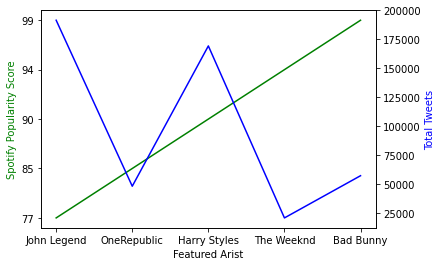

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark Dataframe to Pandas() dataframe
main_artist_tweet_count_df = main_artist_tweet_count_df.toPandas()

x = main_artist_tweet_count_df['name']
y1 = main_artist_tweet_count_df['popularity']
y2 = main_artist_tweet_count_df['tweets_last_month']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('Featured Arist', color = 'black')
ax1.set_ylabel('Spotify Popularity Score', color = 'g')
ax2.set_ylabel('Total Tweets', color = 'b')

plt.show()

For John Legend we see it is not aligned as there are a lot of tweet but popularity is low.. 
For the Weeknd and Bad Bunny it seems to be the other way around, a lot of streams, but less tweets. 

### B. Has any of the features artist increase/decreased popularity in the last month?

In [29]:
import numpy as np
def trendline(index,data, order=1):
    coeffs = np.polyfit(index, list(data), order)
    slope = coeffs[-2]
    if float(slope) == 0:
        return "Neutral"
    return "Increasing" if float(slope) > 0 else "Decreasing"

total_tweet = one_republic_tweet_df.count()
index = list(range(1, total_tweet+1))
sequence = one_republic_tweet_df.select("tweet_count").toPandas().values.reshape(-1)
print(f"Twitter Trend for OneRepublic is : {trendline(index,sequence)}") 

total_tweet = harry_styles_tweet_df.count()
index = list(range(1, total_tweet+1))
sequence = harry_styles_tweet_df.select("tweet_count").toPandas().values.reshape(-1)
print(f"Twitter Trend for Harry Styles is : {trendline(index,sequence)}") 

total_tweet = john_legend_tweet_df.count()
index = list(range(1, total_tweet+1))
sequence = john_legend_tweet_df.select("tweet_count").toPandas().values.reshape(-1)
print(f"Twitter Trend for John Legend is : {trendline(index,sequence)}") 

total_tweet = bad_bunny_tweet_df.count()
index = list(range(1, total_tweet+1))
sequence = bad_bunny_tweet_df.select("tweet_count").toPandas().values.reshape(-1)
print(f"Twitter Trend for Bad Bunny is : {trendline(index,sequence)}") 

total_tweet = the_weekend_tweet_df.count()
index = list(range(1, total_tweet+1))
sequence = the_weekend_tweet_df.select("tweet_count").toPandas().values.reshape(-1)
print(f"Twitter Trend for The Weeknd is : {trendline(index,sequence)}") 

Twitter Trend for OneRepublic is : Decreasing
Twitter Trend for Harry Styles is : Decreasing
Twitter Trend for John Legend is : Decreasing
Twitter Trend for Bad Bunny is : Increasing
Twitter Trend for The Weeknd is : Increasing


#### Reference : https://stackoverflow.com/questions/55649356/how-can-i-detect-if-trend-is-increasing-or-decreasing-in-time-series

<a id='2.3'></a>
## 2.3 Goal 3: Understanding related artist aligned to our feature artist The Weeknd

### A. What is the popularity of the related artists according to the degree of popularity and number of followers? 

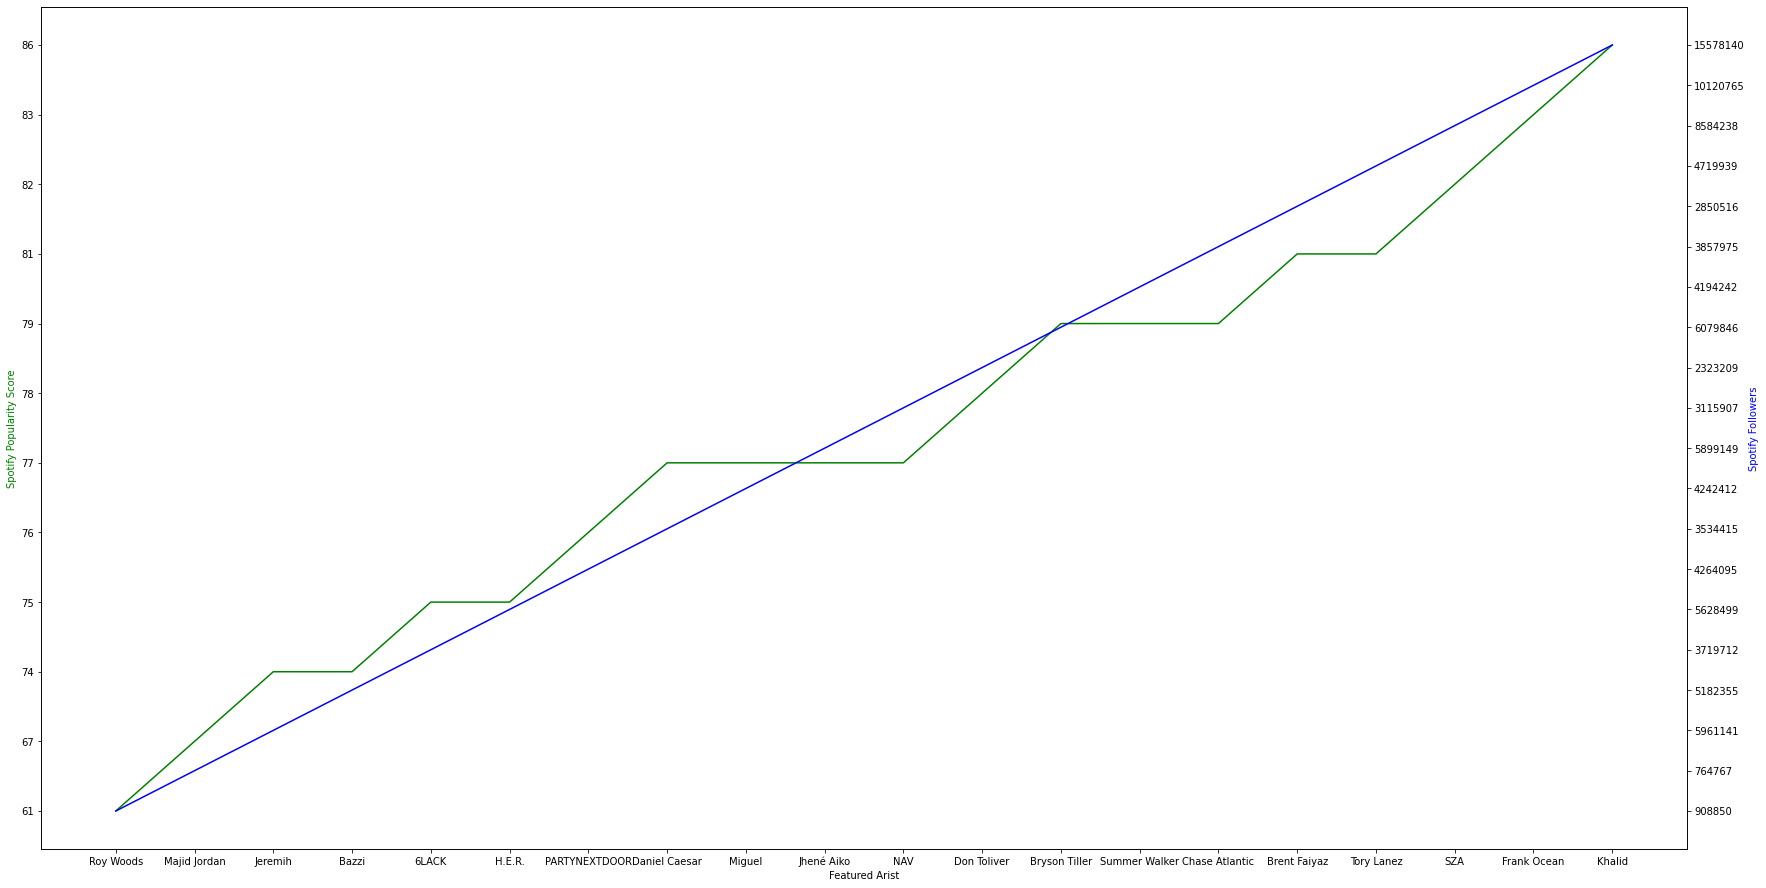

In [30]:
the_weekend_related_artist = related_artist_main_artist.filter(related_artist_main_artist["artist_id"] == '1Xyo4u8uXC1ZmMpatF05PJ')
popularity_meter = the_weekend_related_artist.sort("popularity")
popularity_meter = popularity_meter.toPandas()


x = popularity_meter['name']
y1 = popularity_meter['popularity']
y2 = popularity_meter['followers']

fig, ax1 = plt.subplots()
fig.set_size_inches(29.5, 15.5)


ax2 = ax1.twinx()

ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('Featured Arist', color = 'black')
ax1.set_ylabel('Spotify Popularity Score', color = 'g')
ax2.set_ylabel('Spotify Followers', color = 'b')

plt.show()


### B. What is the popularity of the related artists according to the count of tweets of the last month?
Considering only 'The Weeknd' | Artist Id - 1Xyo4u8uXC1ZmMpatF05PJ

In [31]:
list_of_related_artist = list(the_weekend_related_artist.select("name").toPandas().values.reshape(-1))
print(list_of_related_artist)

['PARTYNEXTDOOR', '6LACK', 'Bryson Tiller', 'Majid Jordan', 'Brent Faiyaz', 'Jeremih', 'Roy Woods', 'Daniel Caesar', 'Miguel', 'Khalid', 'SZA', 'Tory Lanez', 'Jhené Aiko', 'H.E.R.', 'Don Toliver', 'Bazzi', 'Summer Walker', 'Chase Atlantic', 'Frank Ocean', 'NAV']


### Find Twitter Trend for Related Artist for 'The Weeknd'

In [32]:
related_consolidated_tweet_df = consolidated_tweet_df.filter(consolidated_tweet_df.name.isin(list_of_related_artist))
related_artist_sum_tweets_df = related_consolidated_tweet_df.groupBy("name")\
    .agg(sum("tweet_count").alias("total_tweet"))
related_artist_sum_tweets_df.show()

+-------------+-----------+
|         name|total_tweet|
+-------------+-----------+
|Bryson Tiller|       8696|
|PARTYNEXTDOOR|      31552|
|        6LACK|      22678|
| Majid Jordan|        384|
| Brent Faiyaz|      79037|
+-------------+-----------+



In [33]:
matched_list_of_related_artist = list(related_consolidated_tweet_df.dropDuplicates(["name"]).select("name").toPandas().values.reshape(-1))
print(matched_list_of_related_artist)

['Bryson Tiller', 'PARTYNEXTDOOR', '6LACK', 'Majid Jordan', 'Brent Faiyaz']


In [34]:
from collections import defaultdict
related_artist_twitter_trend = defaultdict(int)

for artist in matched_list_of_related_artist:
    df = related_consolidated_tweet_df.filter(related_consolidated_tweet_df.name == artist).sort("start")
    total_tweet = df.count()
    index = list(range(1, total_tweet+1))
    sequence = df.select("tweet_count").toPandas().values.reshape(-1)
    result = trendline(index,sequence)
    print(f"Twitter Trend for {artist} is : {result}")
    result_value = None
    if result == "Increasing":
        result_value = 1
    if result == "Neutral":
        result_value = 0
    if result == "Decreasing":
        result_value = -1
    related_artist_twitter_trend[artist] = result_value

Twitter Trend for Bryson Tiller is : Increasing
Twitter Trend for PARTYNEXTDOOR is : Increasing
Twitter Trend for 6LACK is : Increasing
Twitter Trend for Majid Jordan is : Decreasing
Twitter Trend for Brent Faiyaz is : Increasing


In [35]:
# Find the twiter trends of related artist
map_col = create_map([lit(x) for i in related_artist_twitter_trend.items() for x in i])
related_artist_sum_tweets_df = related_artist_sum_tweets_df.withColumn('trend', map_col[col('name')])
related_artist_sum_tweets_df.show()

# Find the followers for the related artist
popular_score_related_artist = related_artist_sum_tweets_df.join(the_weekend_related_artist,related_artist_sum_tweets_df.name ==  the_weekend_related_artist.name,"left") \
   .select(related_artist_sum_tweets_df["*"], the_weekend_related_artist["followers"])

popular_score_related_artist.show()

+-------------+-----------+-----+
|         name|total_tweet|trend|
+-------------+-----------+-----+
|Bryson Tiller|       8696|    1|
|PARTYNEXTDOOR|      31552|    1|
|        6LACK|      22678|    1|
| Majid Jordan|        384|   -1|
| Brent Faiyaz|      79037|    1|
+-------------+-----------+-----+

+-------------+-----------+-----+---------+
|         name|total_tweet|trend|followers|
+-------------+-----------+-----+---------+
|Bryson Tiller|       8696|    1|  6079846|
|PARTYNEXTDOOR|      31552|    1|  4264095|
|        6LACK|      22678|    1|  3719712|
| Majid Jordan|        384|   -1|   764767|
| Brent Faiyaz|      79037|    1|  2850516|
+-------------+-----------+-----+---------+



### Graph : Total Tweet Vs Spotify Followers

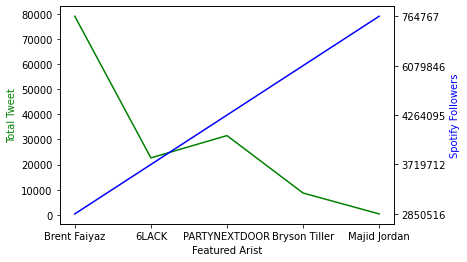

In [36]:
popular_score_related_artist = popular_score_related_artist.sort("followers")
popular_score_related_artist = popular_score_related_artist.toPandas()


x = popular_score_related_artist['name']
y1 = popular_score_related_artist['total_tweet']
y2 = popular_score_related_artist['followers']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('Featured Arist', color = 'black')
ax1.set_ylabel('Total Tweet', color = 'g')
ax2.set_ylabel('Spotify Followers', color = 'b')

plt.show()

### Graph : Tweet Trend Vs Spotify Followers

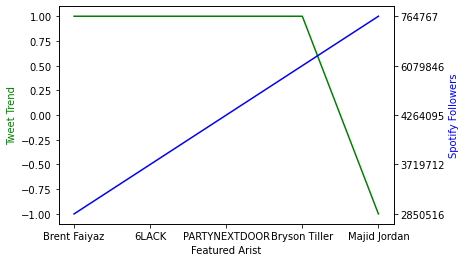

In [37]:
x = popular_score_related_artist['name']
y1 = popular_score_related_artist['trend']
y2 = popular_score_related_artist['followers']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('Featured Arist', color = 'black')
ax1.set_ylabel('Tweet Trend', color = 'g')
ax2.set_ylabel('Spotify Followers', color = 'b')

plt.show()

### C. How many tweets will the weeknd have next month, so that we can anticipate how popular he will be?
Considering only 'The Weeknd' | Artist Id - 1Xyo4u8uXC1ZmMpatF05PJ

In [38]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [39]:
# import os
# os.environ['PYSPARK_SUBMIT_ARGS'] =  '--jars /usr/share/java/mariadb-java-client.jar pyspark-shell'

In [40]:
import findspark
findspark.init()

In [41]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [42]:
from pyspark.sql.session import SparkSession
spark = SparkSession.builder\
.appName("artists recomendation")\
.getOrCreate()
print(f"This cluster relies on Spark '{spark.version}'")

This cluster relies on Spark '3.2.1'


### Importing twitter JSON 


We are going to import 5 json documents obtained from tweeter with the number of twits of the last 31 days. 

In [43]:
DF_6slack = spark.read.json("hdfs://localhost:9000//datalake/raw/aggregate_tweetpy_queries/6lack")

In [44]:
DF_6slack.printSchema()
print(f"This DataFrame has {DF_6slack.count()} rows")
type(DF_6slack)

root
 |-- end: string (nullable = true)
 |-- start: string (nullable = true)
 |-- tweet_count: long (nullable = true)

This DataFrame has 31 rows


pyspark.sql.dataframe.DataFrame

In [45]:
#here we create a column with the file_name from which we will extract the name of the related artist
from pyspark.sql.functions import input_file_name
DF_6slack_5=DF_6slack.withColumn("file_name",input_file_name()).select("end", "tweet_count", "file_name")

In [46]:
DF_6slack_5.limit(5).show()

+--------------------+-----------+--------------------+
|                 end|tweet_count|           file_name|
+--------------------+-----------+--------------------+
|2022-09-01T00:00:...|        272|hdfs://localhost:...|
|2022-09-02T00:00:...|        339|hdfs://localhost:...|
|2022-09-03T00:00:...|        311|hdfs://localhost:...|
|2022-09-04T00:00:...|        213|hdfs://localhost:...|
|2022-09-05T00:00:...|        205|hdfs://localhost:...|
+--------------------+-----------+--------------------+



In [47]:
from pyspark.sql.functions import split
DF_6slack_6=DF_6slack_5.withColumn('json', split(DF_6slack_5['file_name'], '/').getItem(7)).select("end", "tweet_count", "json")

In [48]:
DF_6slack_7=DF_6slack_6.withColumn('artist', split(DF_6slack_6['json'], '.json').getItem(0)).select("end", "tweet_count", "artist")

In [49]:
#The data we are interested in is the day the tweee_count and the artist

from pyspark.sql.functions import date_format
from pyspark.sql.functions import to_date

DF_6slack_8 = DF_6slack_7.withColumn("date",to_date("end"))\
.select("date", "tweet_count", "artist")
DF_6slack_8.limit(5).show()

+----------+-----------+------+
|      date|tweet_count|artist|
+----------+-----------+------+
|2022-09-01|        272| 6lack|
|2022-09-02|        339| 6lack|
|2022-09-03|        311| 6lack|
|2022-09-04|        213| 6lack|
|2022-09-05|        205| 6lack|
+----------+-----------+------+



In [50]:
#now we import the other 4 and we transform them the same way and we join it to previous one
bryson_tiller = spark.read.json("hdfs://localhost:9000//datalake/raw/aggregate_tweetpy_queries/bryson_tiller") 

In [51]:
bryson_tiller1=bryson_tiller.withColumn("file_name",input_file_name()).select("end", "tweet_count", "file_name")
bryson_tiller2=bryson_tiller1.withColumn('json', split(bryson_tiller1['file_name'], '/').getItem(7)).select("end", "tweet_count", "json")
bryson_tiller3=bryson_tiller2.withColumn('artist', split(bryson_tiller2['json'], '.json').getItem(0)).select("end", "tweet_count", "artist")
bryson_tiller=bryson_tiller3.withColumn("date",to_date("end")).select("date", "tweet_count", "artist")

In [52]:
brent_faiyaz = spark.read.json("hdfs://localhost:9000//datalake/raw/aggregate_tweetpy_queries/brent_faiyaz") 

In [53]:
brent_faiyaz1=brent_faiyaz.withColumn("file_name",input_file_name()).select("end", "tweet_count", "file_name")
brent_faiyaz2=brent_faiyaz1.withColumn('json', split(brent_faiyaz1['file_name'], '/').getItem(7)).select("end", "tweet_count", "json")
brent_faiyaz3=brent_faiyaz2.withColumn('artist', split(brent_faiyaz2['json'], '.json').getItem(0)).select("end", "tweet_count", "artist")
brent_faiyaz=brent_faiyaz3.withColumn("date",to_date("end")).select("date", "tweet_count", "artist")

In [54]:
majid_jordan = spark.read.json("hdfs://localhost:9000//datalake/raw/aggregate_tweetpy_queries/majid_jordan") 

In [55]:
majid_jordan1=majid_jordan.withColumn("file_name",input_file_name()).select("end", "tweet_count", "file_name")
majid_jordan2=majid_jordan1.withColumn('json', split(majid_jordan1['file_name'], '/').getItem(7)).select("end", "tweet_count", "json")
majid_jordan3=majid_jordan2.withColumn('artist', split(majid_jordan2['json'], '.json').getItem(0)).select("end", "tweet_count", "artist")
majid_jordan=majid_jordan3.withColumn("date",to_date("end")).select("date", "tweet_count", "artist")

In [56]:
partynextdoor = spark.read.json("hdfs://localhost:9000//datalake/raw/aggregate_tweetpy_queries/partynextdoor") 

In [57]:
partynextdoor1=partynextdoor.withColumn("file_name",input_file_name()).select("end", "tweet_count", "file_name")
partynextdoor2=partynextdoor1.withColumn('json', split(partynextdoor1['file_name'], '/').getItem(7)).select("end", "tweet_count", "json")
partynextdoor3=partynextdoor2.withColumn('artist', split(partynextdoor2['json'], '.json').getItem(0)).select("end", "tweet_count", "artist")
partynextdoor=partynextdoor3.withColumn("date",to_date("end")).select("date", "tweet_count", "artist")

In [58]:
df_concat = DF_6slack_8.union(bryson_tiller).select("date", "tweet_count", "artist")
df_concat1 = df_concat.union(brent_faiyaz).select("date", "tweet_count", "artist")
df_concat2 = df_concat1.union(majid_jordan).select("date", "tweet_count", "artist")
df_concat = df_concat2.union(partynextdoor).select("date", "tweet_count", "artist")
df_concat.count()

186

### Bringing together all artists by count

In [59]:
df_concat.select(['artist']).groupby('artist').agg({'artist': 'count'}).show()

+---------------+-------------+
|         artist|count(artist)|
+---------------+-------------+
|          6lack|           31|
|Bryson%20Tiller|           31|
| Brent%20Faiyaz|           62|
| Majid%20Jordan|           31|
|  Partynextdoor|           31|
+---------------+-------------+



### Time Series with FB.PROPHET to forecast future tweets

In [60]:
# pip install prophet

In [61]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from prophet import Prophet
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [62]:
#Prophet expects date column to be called "ds" and target column as "y"

DF=df_concat.withColumnRenamed("date","ds").withColumnRenamed("tweet_count", "y").select("ds", "y", "artist")
DF.limit(5).show()
DF.dtypes

+----------+---+------+
|        ds|  y|artist|
+----------+---+------+
|2022-09-01|272| 6lack|
|2022-09-02|339| 6lack|
|2022-09-03|311| 6lack|
|2022-09-04|213| 6lack|
|2022-09-05|205| 6lack|
+----------+---+------+



[('ds', 'date'), ('y', 'bigint'), ('artist', 'string')]

In [63]:
#Now we start with the forecast

In [64]:
#Now we will create a Temporary view to run the SQL queries on the dataframe. After this, we run a SQL query to find the count of each artist 

DF.createOrReplaceTempView("tweets")
spark.sql("select artist, count(*) from tweets group by artist order by artist").show()

+---------------+--------+
|         artist|count(1)|
+---------------+--------+
|          6lack|      31|
| Brent%20Faiyaz|      62|
|Bryson%20Tiller|      31|
| Majid%20Jordan|      31|
|  Partynextdoor|      31|
+---------------+--------+



In [65]:
sql = "SELECT artist, ds, sum(y) FROM tweets GROUP BY artist, ds ORDER BY artist, ds"
spark.sql(sql).show()

+------+----------+------+
|artist|        ds|sum(y)|
+------+----------+------+
| 6lack|2022-09-01|   272|
| 6lack|2022-09-02|   339|
| 6lack|2022-09-03|   311|
| 6lack|2022-09-04|   213|
| 6lack|2022-09-05|   205|
| 6lack|2022-09-06|   367|
| 6lack|2022-09-07|   326|
| 6lack|2022-09-08|   316|
| 6lack|2022-09-09|   571|
| 6lack|2022-09-10|  1263|
| 6lack|2022-09-11|  1318|
| 6lack|2022-09-12|   467|
| 6lack|2022-09-13|   327|
| 6lack|2022-09-14|   804|
| 6lack|2022-09-15|  1665|
| 6lack|2022-09-16|  1083|
| 6lack|2022-09-17|   753|
| 6lack|2022-09-18|   370|
| 6lack|2022-09-19|   332|
| 6lack|2022-09-20|  3176|
+------+----------+------+
only showing top 20 rows



In [66]:
#create a schema for our return object

from pyspark.sql.types import *
result_schema = StructType([
                  StructField('ds', TimestampType()),
                  StructField('artist', StringType()),
                  StructField('y', DoubleType()),
                  StructField('yhat', DoubleType()),
                  StructField('yhat_upper', DoubleType()),
                  StructField('yhat_lower', DoubleType())
])

In [67]:
#from the Pyspark SQL function we will import Pandas UDF and UDF type and define a function that will have facebook Prophet code

In [68]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_tweets(history_pd):

    # instantiate the model, configure the parameters
    model = Prophet(
        interval_width=0.95,
        growth='linear',
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=False,
        seasonality_mode='additive'
    )

    # fit the model
    model.fit(history_pd)

    # configure predictions
    future_pd = model.make_future_dataframe(
        periods=15,
        freq='d',
        include_history=True
    )

    # make predictions
    forecast_pd = model.predict(future_pd)

    
    f_pd = forecast_pd[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].set_index('ds')
    ra_pd = history_pd[['ds', 'artist', 'y']].set_index('ds')
    result_pd = f_pd.join(ra_pd, how='left')
    result_pd.reset_index(level=0, inplace=True)
    result_pd['artist'] = history_pd['artist'].iloc[0]
    return result_pd[['ds', 'artist', 'y', 'yhat', 'yhat_upper', 'yhat_lower']]

In [69]:
from pyspark.sql.functions import current_date
results = (DF.groupby('artist').apply(forecast_tweets).withColumn('training_date', current_date()))
results.cache()
results.show()

/opt/spark3/python/pyspark/sql/pandas/group_ops.py:81: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(
20:22:47 - cmdstanpy - INFO - Chain [1] start processing           (0 + 2) / 20]
20:22:47 - cmdstanpy - INFO - Chain [1] start processing
20:22:47 - cmdstanpy - INFO - Chain [1] done processing
20:22:47 - cmdstanpy - INFO - Chain [1] done processing


+-------------------+--------------+------+-------------------+-----------------+-------------------+-------------+
|                 ds|        artist|     y|               yhat|       yhat_upper|         yhat_lower|training_date|
+-------------------+--------------+------+-------------------+-----------------+-------------------+-------------+
|2022-09-01 00:00:00|Brent%20Faiyaz|1002.0|   4557.81328720035|8828.497895014902| 23.625732351086075|   2022-11-12|
|2022-09-01 00:00:00|Brent%20Faiyaz|1002.0|   4557.81328720035|8828.497895014902| 23.625732351086075|   2022-11-12|
|2022-09-02 00:00:00|Brent%20Faiyaz|1383.0| 1289.8405355743014|5659.548494289252|-2800.3983779360783|   2022-11-12|
|2022-09-02 00:00:00|Brent%20Faiyaz|1383.0| 1289.8405355743014|5659.548494289252|-2800.3983779360783|   2022-11-12|
|2022-09-03 00:00:00|Brent%20Faiyaz|1217.0|  292.9553406034613|4562.171630131309| -4062.633797604891|   2022-11-12|
|2022-09-03 00:00:00|Brent%20Faiyaz|1217.0|  292.9553406034613|4562.1716

In [70]:
results.count()

20:22:50 - cmdstanpy - INFO - Chain [1] start processing
20:22:50 - cmdstanpy - INFO - Chain [1] start processing         (25 + 2) / 200]
20:22:50 - cmdstanpy - INFO - Chain [1] done processing
20:22:50 - cmdstanpy - INFO - Chain [1] done processing
20:22:52 - cmdstanpy - INFO - Chain [1] start processing         (25 + 3) / 200]
20:22:52 - cmdstanpy - INFO - Chain [1] done processing          (39 + 2) / 200]


261

Verifying that the 15 forecasted days are in the DF 

In [71]:
results.createOrReplaceTempView('forecasted')
spark.sql("SELECT artist, count(*) FROM  forecasted GROUP BY artist").show()

+---------------+--------+
|         artist|count(1)|
+---------------+--------+
| Brent%20Faiyaz|      77|
|  Partynextdoor|      46|
|          6lack|      46|
|Bryson%20Tiller|      46|
| Majid%20Jordan|      46|
+---------------+--------+



In [72]:
results.dtypes

[('ds', 'timestamp'),
 ('artist', 'string'),
 ('y', 'double'),
 ('yhat', 'double'),
 ('yhat_upper', 'double'),
 ('yhat_lower', 'double'),
 ('training_date', 'date')]

In [73]:
results.printSchema()

root
 |-- ds: timestamp (nullable = true)
 |-- artist: string (nullable = true)
 |-- y: double (nullable = true)
 |-- yhat: double (nullable = true)
 |-- yhat_upper: double (nullable = true)
 |-- yhat_lower: double (nullable = true)
 |-- training_date: date (nullable = false)



In [74]:
final_df = results.toPandas()

In [75]:
final_df

ds          artist       y         yhat   yhat_upper   yhat_lower  \
0   2022-09-01  Brent%20Faiyaz  1002.0  4557.813287  8828.497895    23.625732   
1   2022-09-01  Brent%20Faiyaz  1002.0  4557.813287  8828.497895    23.625732   
2   2022-09-02  Brent%20Faiyaz  1383.0  1289.840536  5659.548494 -2800.398378   
3   2022-09-02  Brent%20Faiyaz  1383.0  1289.840536  5659.548494 -2800.398378   
4   2022-09-03  Brent%20Faiyaz  1217.0   292.955341  4562.171630 -4062.633798   
..         ...             ...     ...          ...          ...          ...   
256 2022-10-12  Majid%20Jordan     NaN    15.115148    30.257949     0.322278   
257 2022-10-13  Majid%20Jordan     NaN    11.068633    25.989592    -4.043416   
258 2022-10-14  Majid%20Jordan     NaN    13.069839    29.009479    -2.239519   
259 2022-10-15  Majid%20Jordan     NaN     9.871028    25.456207    -5.703449   
260 2022-10-16  Majid%20Jordan     NaN     7.923745    23.244238    -7.203992   

    training_date  
0      2022-11-12  
1      2022-11-12  
2      2022-11-12  
3      2022-11-12  
4      2022-11-12  
..            ...  
256    2022-11-12  
257    2022-11-12  
258    2022-11-12  
259    2022-11-12  
260    2022-11-12  

[261 rows x 7 columns]

In [76]:
#If we want to see the whole DF
#with pd.option_context('display.max_rows', None,
#                       'display.max_columns', None,
#                       'display.precision', 3,
#                       ):
#    print(final_df)

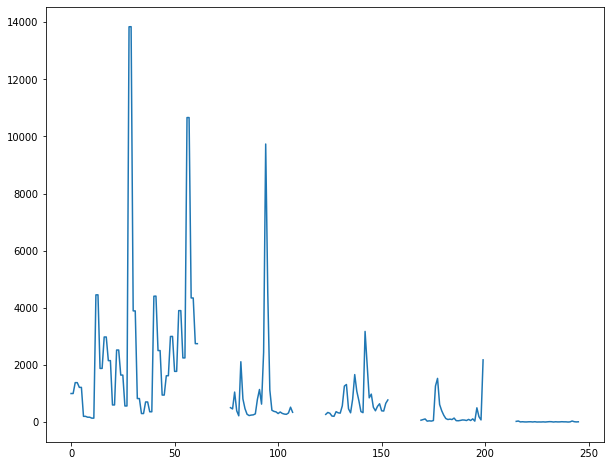

In [77]:
y1 = final_df.iloc[:,2]
plt.plot(y1)
plt.show()

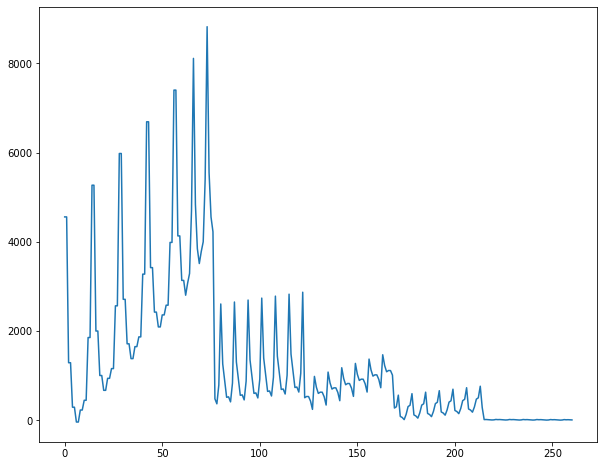

In [78]:
y2 = final_df.iloc[:,3]
plt.plot(y2)
plt.show()

### Exporting Results to MariaDB

In [79]:
results.limit(5).show()

+-------------------+--------------+------+------------------+-----------------+-------------------+-------------+
|                 ds|        artist|     y|              yhat|       yhat_upper|         yhat_lower|training_date|
+-------------------+--------------+------+------------------+-----------------+-------------------+-------------+
|2022-09-01 00:00:00|Brent%20Faiyaz|1002.0|  4557.81328720035|8828.497895014902| 23.625732351086075|   2022-11-12|
|2022-09-01 00:00:00|Brent%20Faiyaz|1002.0|  4557.81328720035|8828.497895014902| 23.625732351086075|   2022-11-12|
|2022-09-02 00:00:00|Brent%20Faiyaz|1383.0|1289.8405355743014|5659.548494289252|-2800.3983779360783|   2022-11-12|
|2022-09-02 00:00:00|Brent%20Faiyaz|1383.0|1289.8405355743014|5659.548494289252|-2800.3983779360783|   2022-11-12|
|2022-09-03 00:00:00|Brent%20Faiyaz|1217.0| 292.9553406034613|4562.171630131309| -4062.633797604891|   2022-11-12|
+-------------------+--------------+------+------------------+-----------------+

In [80]:
#reshaping the result before sending it to the serving layer

from pyspark.sql.functions import date_format
from pyspark.sql.functions import to_date

results_mdb = results.withColumn("dates",to_date("ds"))\
.select("dates", "artist", "y", "yhat")
results_mdb.limit(5).show()

+----------+--------------+------+------------------+
|     dates|        artist|     y|              yhat|
+----------+--------------+------+------------------+
|2022-09-01|Brent%20Faiyaz|1002.0|  4557.81328720035|
|2022-09-01|Brent%20Faiyaz|1002.0|  4557.81328720035|
|2022-09-02|Brent%20Faiyaz|1383.0|1289.8405355743014|
|2022-09-02|Brent%20Faiyaz|1383.0|1289.8405355743014|
|2022-09-03|Brent%20Faiyaz|1217.0| 292.9553406034613|
+----------+--------------+------+------------------+



In [81]:
results_mdb.printSchema()

root
 |-- dates: date (nullable = true)
 |-- artist: string (nullable = true)
 |-- y: double (nullable = true)
 |-- yhat: double (nullable = true)



In [82]:
results_mdb2 = results_mdb.withColumn("tweets", results_mdb.y.cast('integer'))

In [83]:
results_mdb3 = results_mdb2.withColumn("forecasted_tweets", results_mdb.yhat.cast('integer'))

In [84]:
results_mdb=results_mdb3.select("dates", "artist", "tweets", "forecasted_tweets")

In [85]:
results_mdb.printSchema()

root
 |-- dates: date (nullable = true)
 |-- artist: string (nullable = true)
 |-- tweets: integer (nullable = true)
 |-- forecasted_tweets: integer (nullable = true)



In [86]:
results_mdb.limit(5).show()

+----------+--------------+------+-----------------+
|     dates|        artist|tweets|forecasted_tweets|
+----------+--------------+------+-----------------+
|2022-09-01|Brent%20Faiyaz|  1002|             4557|
|2022-09-01|Brent%20Faiyaz|  1002|             4557|
|2022-09-02|Brent%20Faiyaz|  1383|             1289|
|2022-09-02|Brent%20Faiyaz|  1383|             1289|
|2022-09-03|Brent%20Faiyaz|  1217|              292|
+----------+--------------+------+-----------------+



In [87]:
from pyspark.sql.functions import when
results_mdb = results_mdb.withColumn("hist_forecast", when(results_mdb.tweets.isNull(), results_mdb.forecasted_tweets)
                                  .otherwise(results_mdb.tweets))

In [88]:
results_mdb.show(20)

+----------+--------------+------+-----------------+-------------+
|     dates|        artist|tweets|forecasted_tweets|hist_forecast|
+----------+--------------+------+-----------------+-------------+
|2022-09-01|Brent%20Faiyaz|  1002|             4557|         1002|
|2022-09-01|Brent%20Faiyaz|  1002|             4557|         1002|
|2022-09-02|Brent%20Faiyaz|  1383|             1289|         1383|
|2022-09-02|Brent%20Faiyaz|  1383|             1289|         1383|
|2022-09-03|Brent%20Faiyaz|  1217|              292|         1217|
|2022-09-03|Brent%20Faiyaz|  1217|              292|         1217|
|2022-09-04|Brent%20Faiyaz|   203|              -39|          203|
|2022-09-04|Brent%20Faiyaz|   203|              -39|          203|
|2022-09-05|Brent%20Faiyaz|   173|              229|          173|
|2022-09-05|Brent%20Faiyaz|   173|              229|          173|
|2022-09-06|Brent%20Faiyaz|   140|              447|          140|
|2022-09-06|Brent%20Faiyaz|   140|              447|          

In [89]:
results_mdb.printSchema()

root
 |-- dates: date (nullable = true)
 |-- artist: string (nullable = true)
 |-- tweets: integer (nullable = true)
 |-- forecasted_tweets: integer (nullable = true)
 |-- hist_forecast: integer (nullable = true)



In [90]:
results_mdb.filter(col("hist_forecast").isNull()).show()

+-----+------+------+-----------------+-------------+
|dates|artist|tweets|forecasted_tweets|hist_forecast|
+-----+------+------+-----------------+-------------+
+-----+------+------+-----------------+-------------+



In [91]:
url = "jdbc:mysql://localhost:3306/GROUPA"
table = "Forecast"
mode = "overwrite"
props = {"user":"osbdet",
         "password":"osbdet123$", 
         "driver":"org.mariadb.jdbc.Driver"}

In [92]:
results_mdb.write.jdbc(url,table,mode,props)

<a id='2.4'></a>
## 2.4 Goal 4: What is our reccommendation of a song's lineup?

### A. What are the top 5 songs per featured artists?
### B. Has any of those top songs been in the top charts for 2022? For how many weeks?
### C. From the charts find the song name which has been in the maximum in the top charts!

In [120]:
spotify_top_charts_22_cleaned,top_tracks.show()

+-----------+------------+--------------------+----------------+------------+--------------------+--------------------+
|duration_ms|release_date|          artists_id|            name|artists_name|                  id|           artist_id|
+-----------+------------+--------------------+----------------+------------+--------------------+--------------------+
|     178567|  2022-05-06|4q3ewBCX7sLwd24eu...| Me Porto Bonito|   Bad Bunny|6Sq7ltF9Qa7SNFBsV...|4q3ewBCX7sLwd24eu...|
|     243716|  2022-05-06|4q3ewBCX7sLwd24eu...|Tití Me Preguntó|   Bad Bunny|1IHWl5LamUGEuP4oz...|4q3ewBCX7sLwd24eu...|
|     213061|  2022-05-06|4q3ewBCX7sLwd24eu...|          Efecto|   Bad Bunny|5Eax0qFko2dh7Rl2l...|4q3ewBCX7sLwd24eu...|
|     258298|  2022-05-06|4q3ewBCX7sLwd24eu...|   Ojitos Lindos|   Bad Bunny|3k3NWokhRRkEPhCzP...|4q3ewBCX7sLwd24eu...|
|     245939|  2022-05-06|4q3ewBCX7sLwd24eu...|     Moscow Mule|   Bad Bunny|6Xom58OOXk2SoU711...|4q3ewBCX7sLwd24eu...|
|     173119|  2022-05-06|4q3ewBCX7sLwd2

(DataFrame[uri: string, artist_names: string, track_name: string, peak_rank: int, weeks_on_chart: int, danceability: double, energy: double, key: int, loudness: double, mode: int, speechiness: double, acousticness: double, instrumentalness: double, liveness: double, tempo: double, time_signature: int, duration_ms: int],
 None)

In [122]:
spotify_top_charts_22_cleaned.show()

+--------------------+--------------------+--------------------+---------+--------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+--------------+-----------+
|                 uri|        artist_names|          track_name|peak_rank|weeks_on_chart|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|  tempo|time_signature|duration_ms|
+--------------------+--------------------+--------------------+---------+--------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+--------------+-----------+
|4zN21mbAuaD0Wqtma...|James Hype, Miggy...|             Ferrari|       36|            10|       0.847|  0.69|  1|  -7.877|   0|     0.0493|      0.0127|          6.0E-5|  0.0526|125.004|             4|     186662|
|1E5Xu8dur0fAjSP1V...|          The Weeknd|        Best Friends|       26|             2|       0.737| 0.564|  4|  -7.045|   0|      0.105|     

Showing Any Top 5 Song for Artist : OneRepublic
+---------------+
|name           |
+---------------+
|I Ain't Worried|
|Counting Stars |
|Sunshine       |
|West Coast     |
|Secrets        |
+---------------+
only showing top 5 rows

Showing Song for Artist : OneRepublic on the Charts Week sorted by Week on Chart
+---------------+------+--------------------+------------+--------------+
|     track_name|energy|           artist_id|artist_names|weeks_on_chart|
+---------------+------+--------------------+------------+--------------+
|I Ain't Worried| 0.797|5Pwc4xIPtQLFEnJri...| OneRepublic|            10|
+---------------+------+--------------------+------------+--------------+

Song which has been in the maximum in the top charts is : I Ain't Worried with 10 week(s) on Charts 


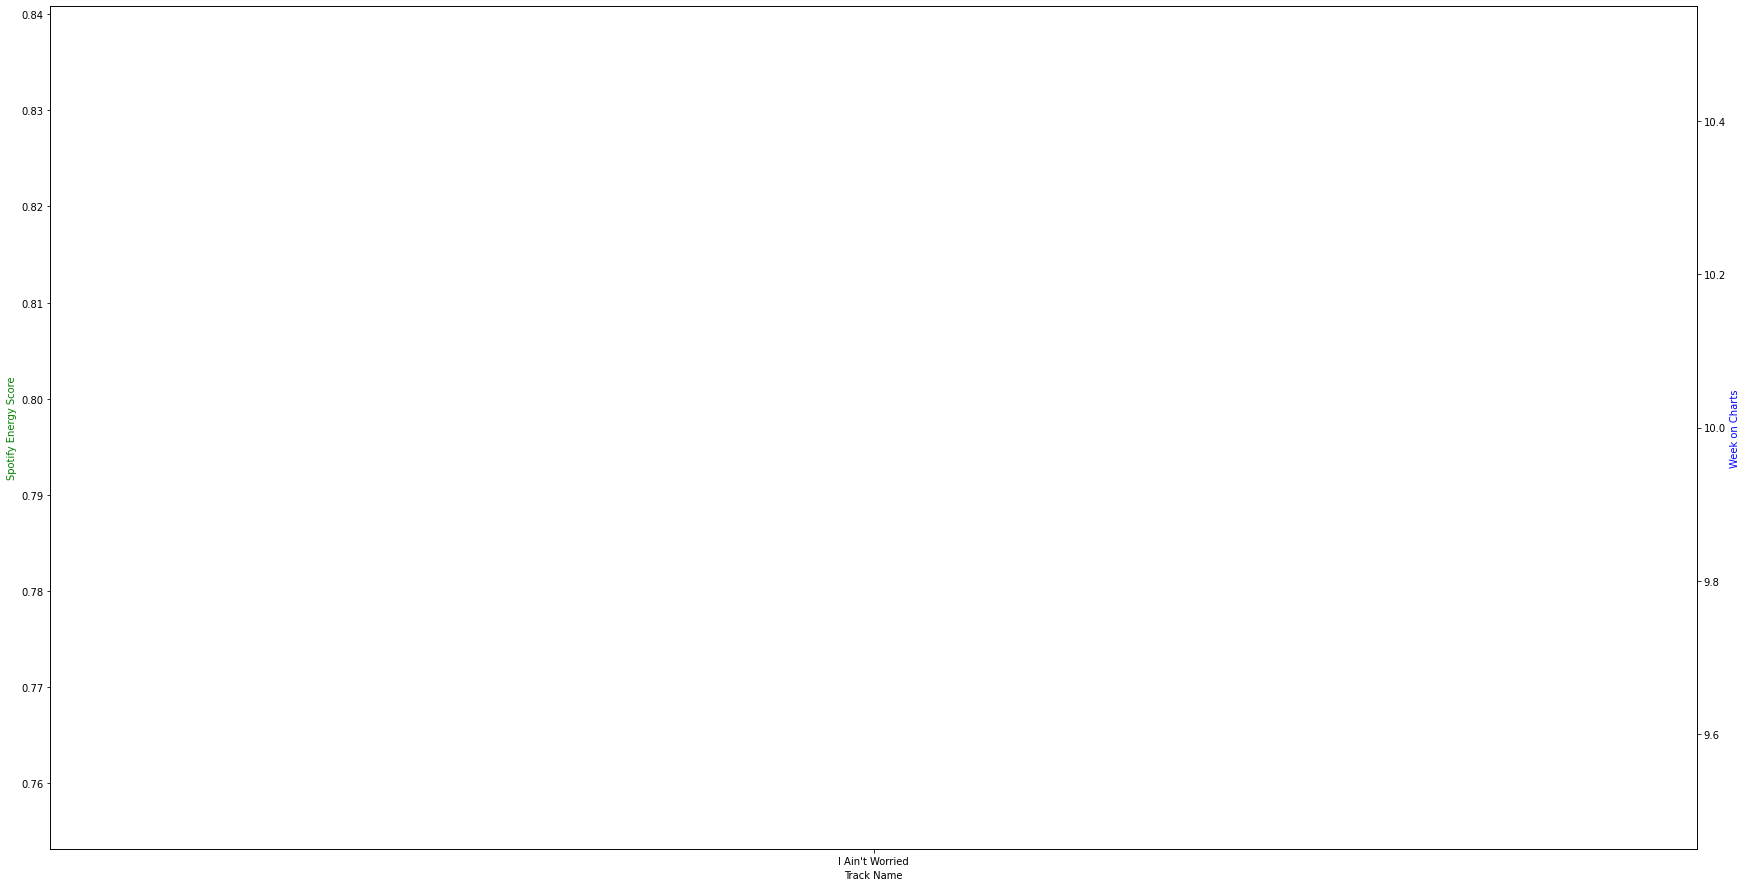

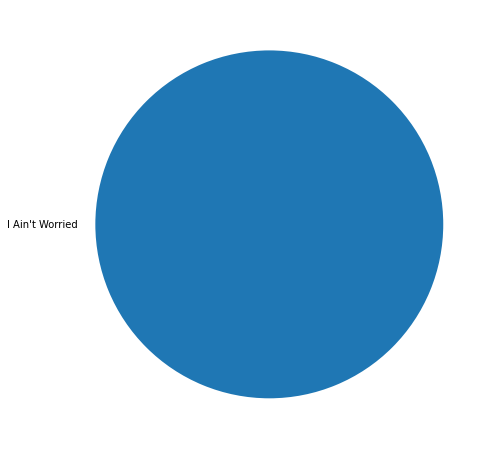

Showing Any Top 5 Song for Artist : Harry Styles
+------------------+
|name              |
+------------------+
|As It Was         |
|Late Night Talking|
|Watermelon Sugar  |
|Matilda           |
|Adore You         |
+------------------+
only showing top 5 rows

Showing Song for Artist : Harry Styles on the Charts Week sorted by Week on Chart
+--------------------+------+--------------------+------------+--------------+
|          track_name|energy|           artist_id|artist_names|weeks_on_chart|
+--------------------+------+--------------------+------------+--------------+
|        Little Freak| 0.535|6KImCVD70vtIoJWnq...|Harry Styles|             2|
|            Daylight| 0.445|6KImCVD70vtIoJWnq...|Harry Styles|             2|
|Music For a Sushi...| 0.715|6KImCVD70vtIoJWnq...|Harry Styles|            12|
|             Matilda| 0.294|6KImCVD70vtIoJWnq...|Harry Styles|            12|
|  Late Night Talking| 0.728|6KImCVD70vtIoJWnq...|Harry Styles|            12|
|           As It Was| 

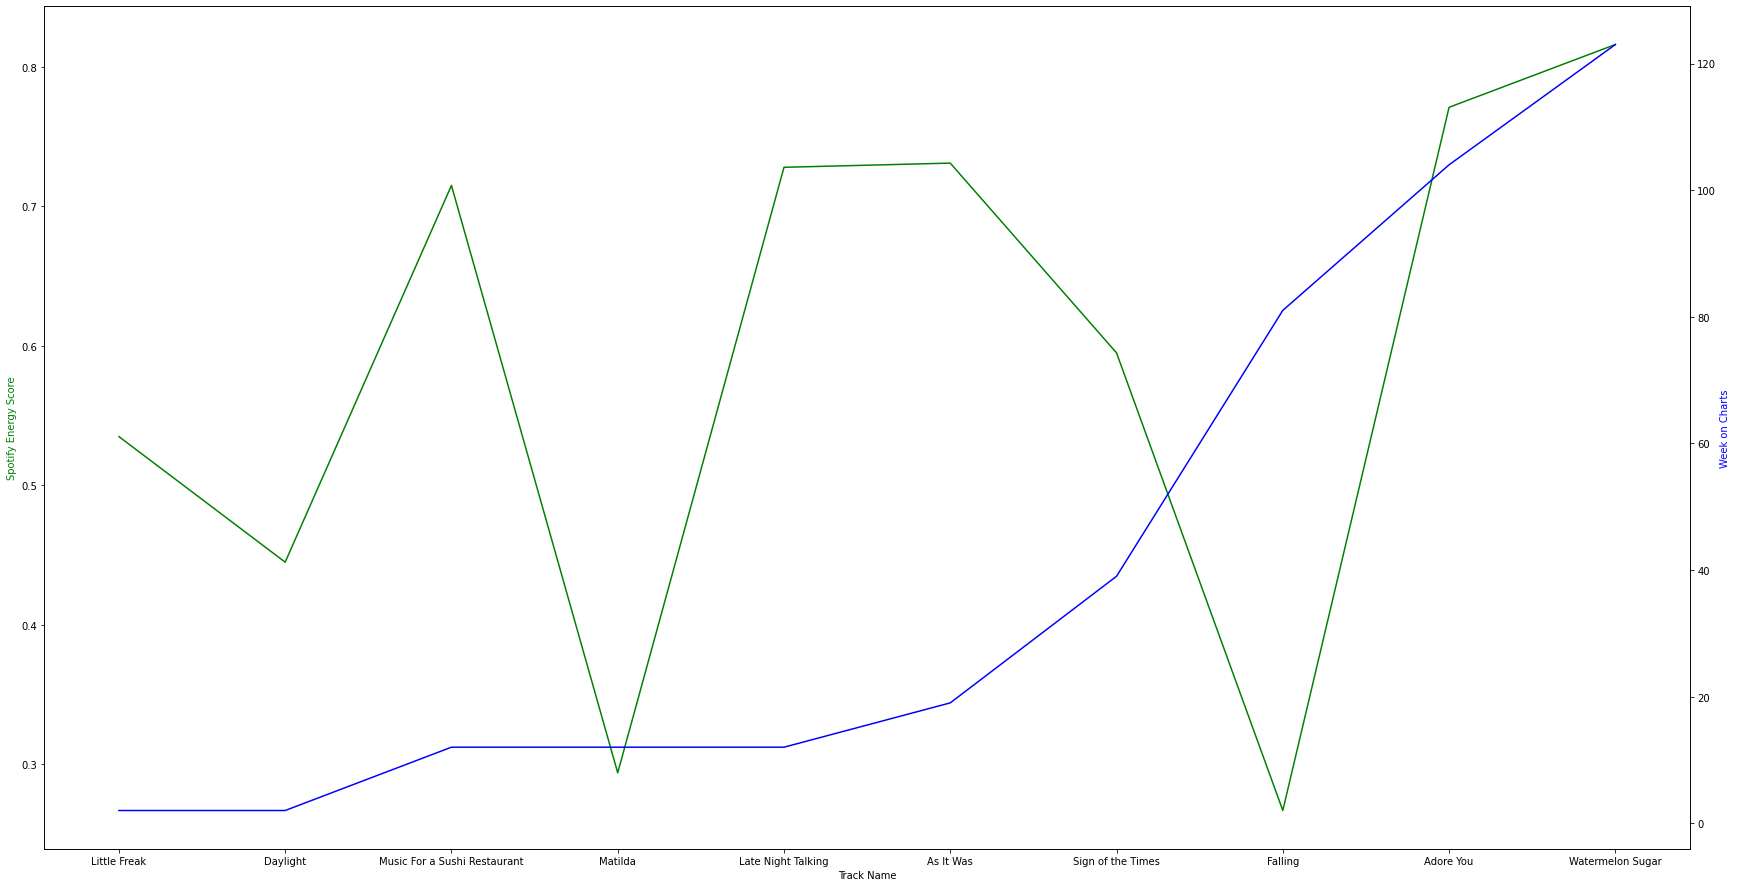

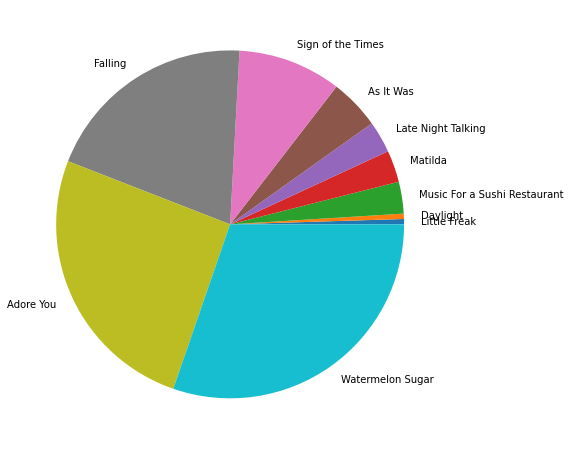

Showing Any Top 5 Song for Artist : The Weeknd
+-----------------+
|name             |
+-----------------+
|Blinding Lights  |
|I Was Never There|
|Starboy          |
|Call Out My Name |
|Save Your Tears  |
+-----------------+
only showing top 5 rows

Showing Song for Artist : The Weeknd on the Charts Week sorted by Week on Chart
+--------------------+------+--------------------+--------------------+--------------+
|          track_name|energy|           artist_id|        artist_names|weeks_on_chart|
+--------------------+------+--------------------+--------------------+--------------+
|   I Was Never There| 0.737|1Xyo4u8uXC1ZmMpat...|The Weeknd, Gesaf...|            10|
|Lost in the Fire ...| 0.671|1Xyo4u8uXC1ZmMpat...|Gesaffelstein, Th...|            21|
|         Die For You| 0.525|1Xyo4u8uXC1ZmMpat...|          The Weeknd|            26|
|           You Right| 0.621|1Xyo4u8uXC1ZmMpat...|Doja Cat, The Weeknd|            39|
|    Call Out My Name| 0.593|1Xyo4u8uXC1ZmMpat...|         

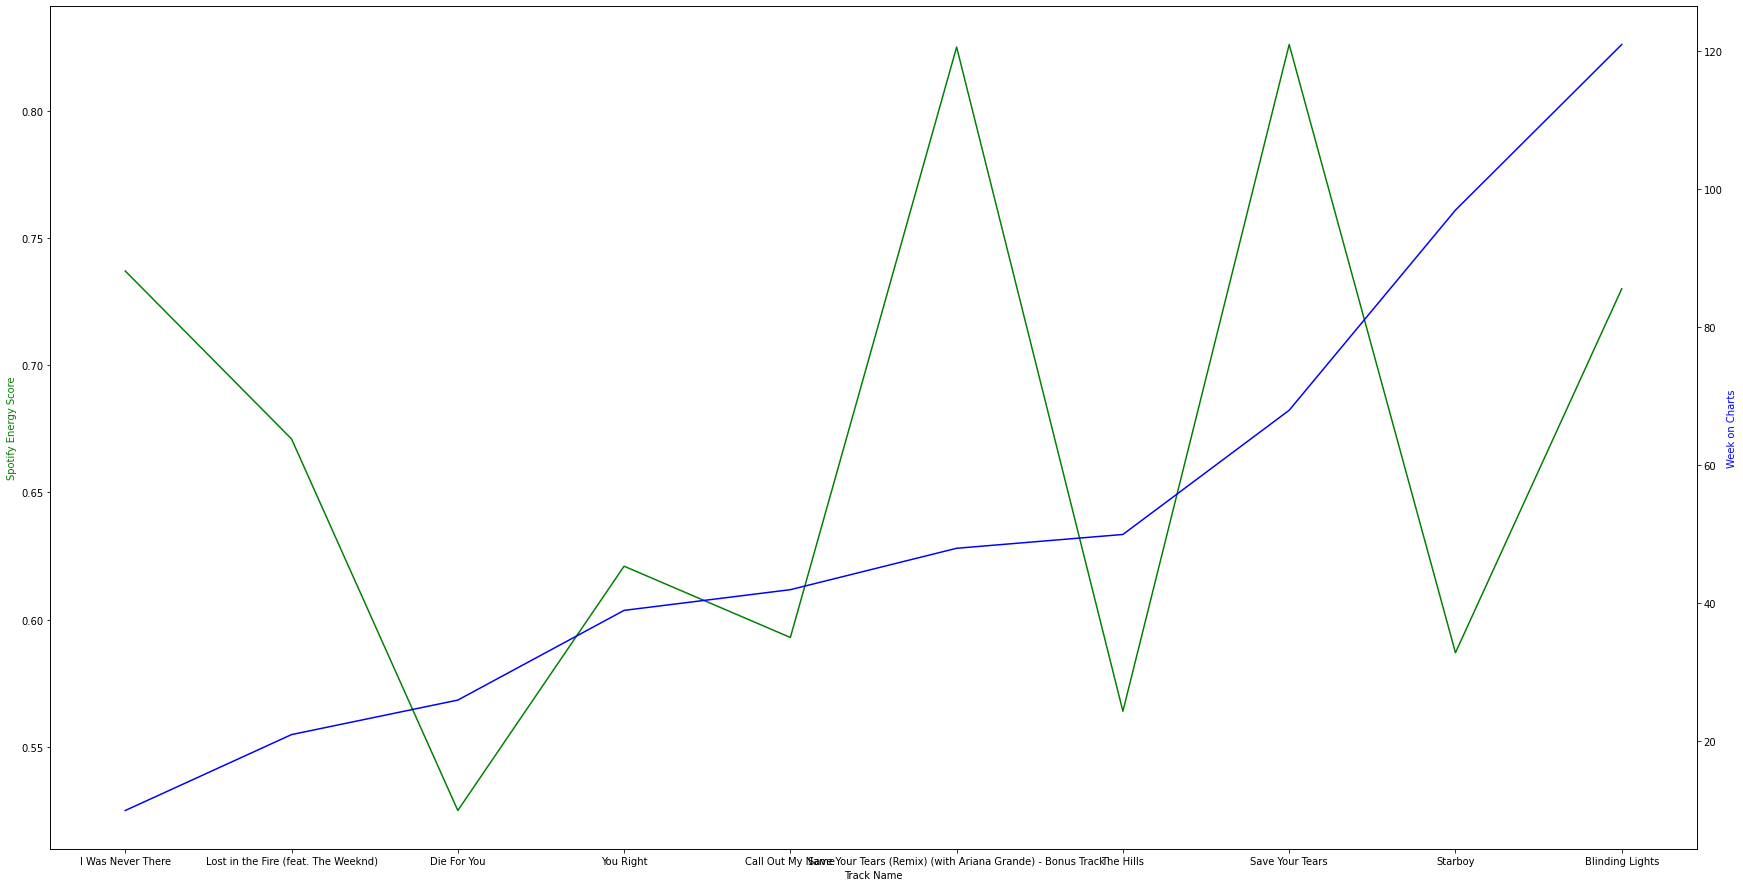

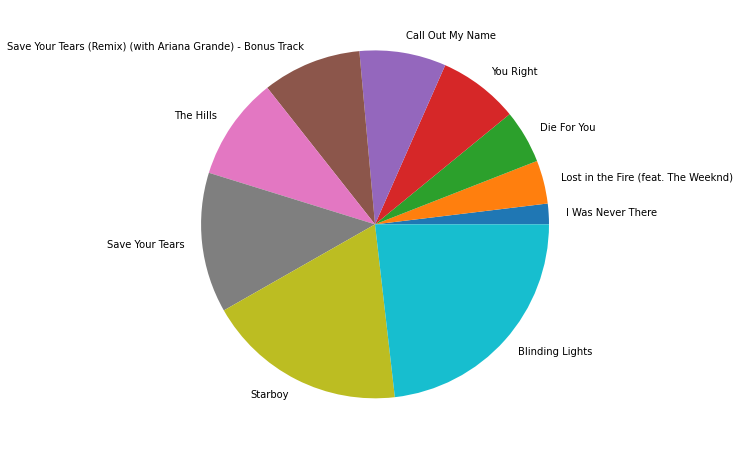

Showing Any Top 5 Song for Artist : John Legend
+------------------------------------------------------------------+
|name                                                              |
+------------------------------------------------------------------+
|All of Me                                                         |
|GOD DID (feat. Rick Ross, Lil Wayne, Jay-Z, John Legend & Fridayy)|
|Wonder Woman                                                      |
|Minefields                                                        |
|Nervous                                                           |
+------------------------------------------------------------------+
only showing top 5 rows

Showing Song for Artist : John Legend on the Charts Week sorted by Week on Chart
+----------+------+--------------------+------------+--------------+
|track_name|energy|           artist_id|artist_names|weeks_on_chart|
+----------+------+--------------------+------------+--------------+
| All of Me| 0.264

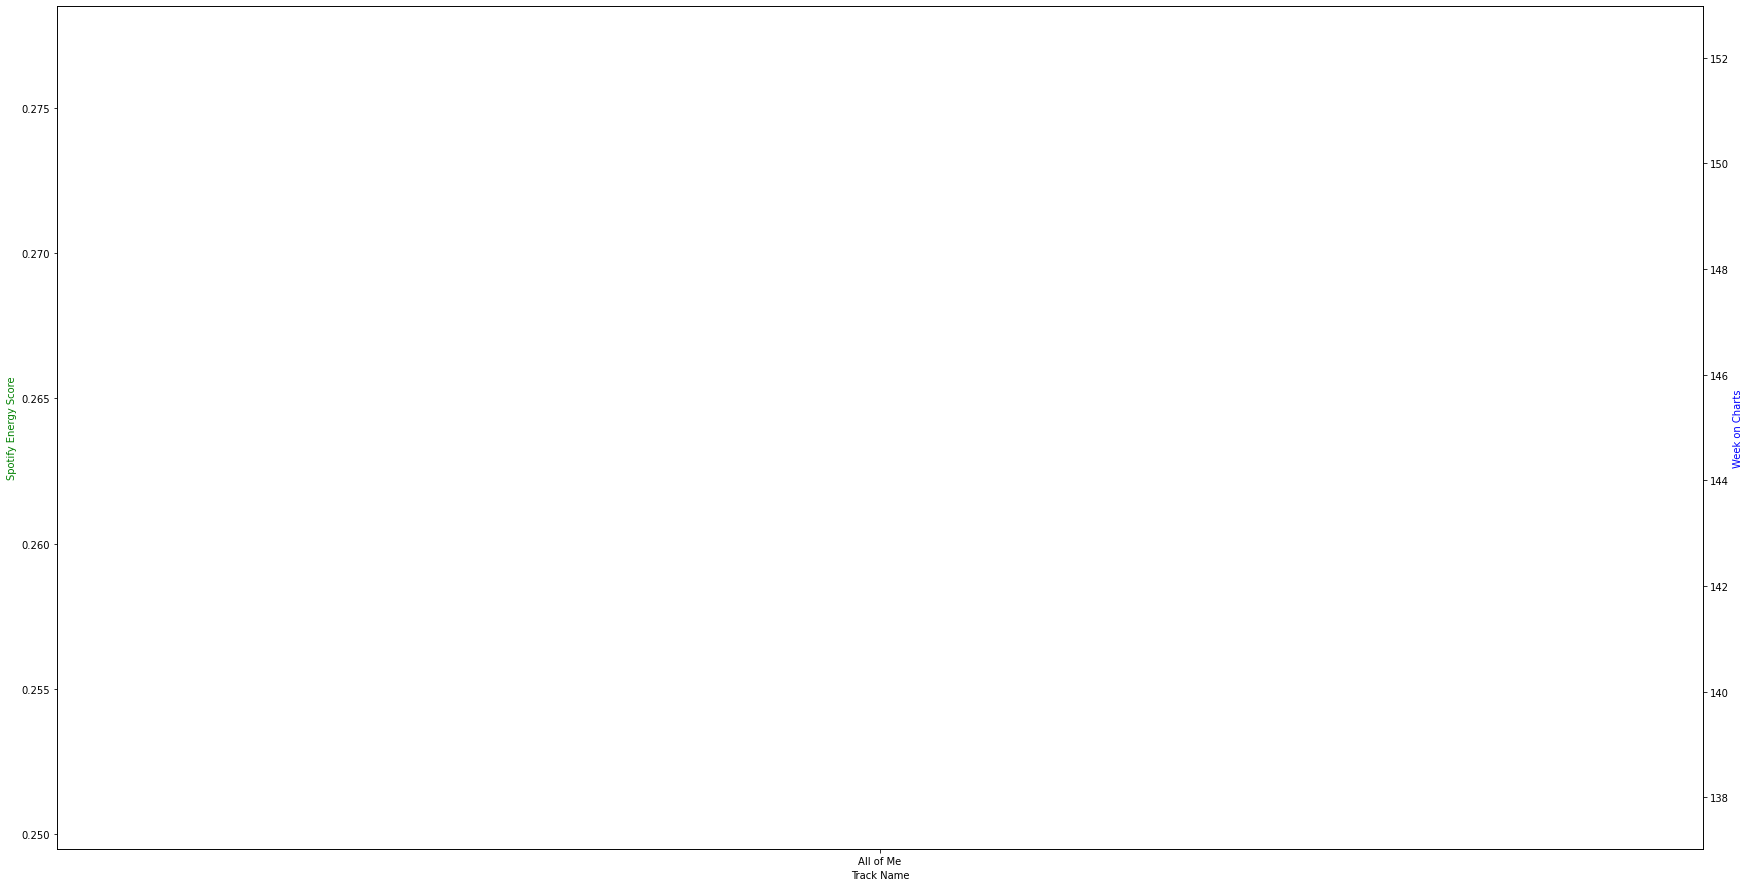

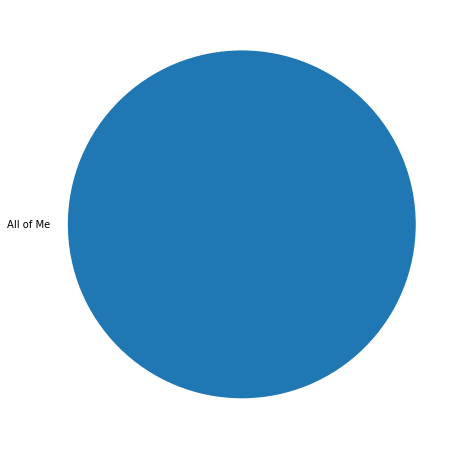

Showing Any Top 5 Song for Artist : Bad Bunny
+----------------+
|name            |
+----------------+
|Me Porto Bonito |
|Tití Me Preguntó|
|Efecto          |
|Ojitos Lindos   |
|Moscow Mule     |
+----------------+
only showing top 5 rows

Showing Song for Artist : Bad Bunny on the Charts Week sorted by Week on Chart
+----------------+------+--------------------+--------------------+--------------+
|      track_name|energy|           artist_id|        artist_names|weeks_on_chart|
+----------------+------+--------------------+--------------------+--------------+
|        Neverita| 0.498|4q3ewBCX7sLwd24eu...|           Bad Bunny|            14|
|           Tarot| 0.684|4q3ewBCX7sLwd24eu...|Bad Bunny, Jhay C...|            14|
|          Efecto| 0.475|4q3ewBCX7sLwd24eu...|           Bad Bunny|            14|
|Tití Me Preguntó| 0.715|4q3ewBCX7sLwd24eu...|           Bad Bunny|            14|
|           Party| 0.799|4q3ewBCX7sLwd24eu...|Bad Bunny, Rauw A...|            14|
|   Ojitos Lind

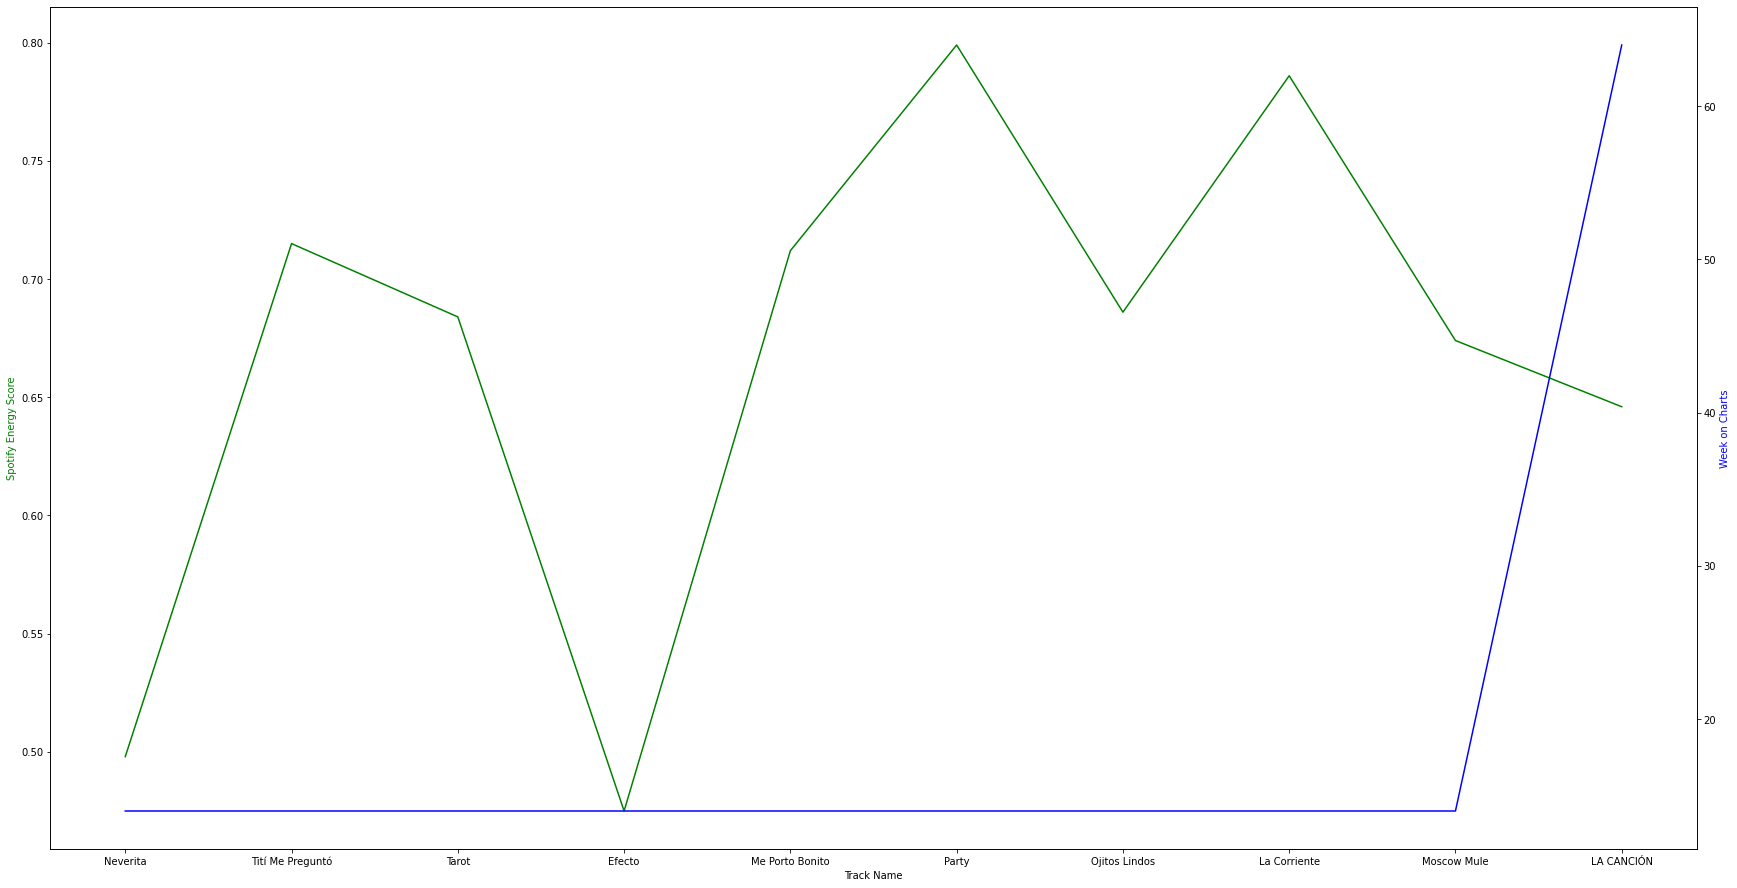

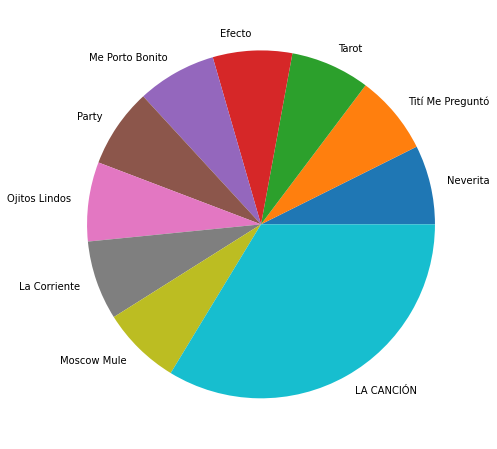

In [93]:
# Clean up top-chart Song Id - spotify:track:02MWAaffLxlfxAUY7c5dvx -->  02MWAaffLxlfxAUY7c5dvx
spotify_top_charts_22_cleaned = spotify_top_charts_22.withColumn("uri", split(spotify_top_charts_22['uri'], ':').getItem(2))

for artist,artist_id in main_artist_dict.items():
    print(f"Showing Any Top 5 Song for Artist : {artist}")
    top_tracks = top_tracks_main_artist.filter(top_tracks_main_artist["artist_id"]==artist_id)
    top_tracks.select("name").show(5, truncate=False)
    
    print(f"Showing Song for Artist : {artist} on the Charts Week sorted by Week on Chart")
    song_on_the_chart = top_tracks.join(spotify_top_charts_22_cleaned,top_tracks.id ==  spotify_top_charts_22_cleaned.uri,"inner")
    song_on_the_chart = song_on_the_chart.select(["track_name", "energy","artist_id", "artist_names", "weeks_on_chart"]).sort("weeks_on_chart")
    song_on_the_chart.show()
    
    print(f"Song which has been in the maximum in the top charts is : {song_on_the_chart.tail(1)[0].__getitem__('track_name')} with {song_on_the_chart.tail(1)[0].__getitem__('weeks_on_chart')} week(s) on Charts ")

    song_popularity_meter = song_on_the_chart.toPandas()

    x = song_popularity_meter['track_name']
    y1 = song_popularity_meter['energy']
    y2 = song_popularity_meter['weeks_on_chart']

    fig, ax1 = plt.subplots()
    fig.set_size_inches(29.5, 15.5)

    ax2 = ax1.twinx()

    ax1.plot(x, y1, 'g-')
    ax2.plot(x, y2, 'b-')

    ax1.set_xlabel('Track Name', color = 'black')
    ax1.set_ylabel('Spotify Energy Score', color = 'g')
    ax2.set_ylabel('Week on Charts', color = 'b')
    
    plt.show()
    plt.pie(song_popularity_meter['weeks_on_chart'], labels=song_popularity_meter['track_name'])

    plt.show()

### Spark Machine Learning - K-Means Cluster

K-Means Clustering is an unsupervised learning algorithm that is used to solve the clustering problems in machine learning or data science. In this topic, we will learn what is K-means clustering algorithm, how the algorithm works, along with the Python implementation of k-means clustering.

### Load Historical Songs

In [94]:
historical_songs_df = (spark.read
            .option("header","true")
            .option("inferSchema","true")
            .csv("HistoricalTracks.csv")            
            .distinct())

In [95]:
# Create A feature Vector
from pyspark.ml.feature import VectorAssembler

feature_columns = ["acoustics", "danceability", "instrumentalness", "energy"  ,"speechiness"]

assembler = VectorAssembler(inputCols=feature_columns,outputCol='featureVector')
historical_songs_df = assembler.transform(historical_songs_df)
historical_songs_df.show()

+-------+--------------------+----------+--------------------+--------------------+------------+------------------+----------------+--------+--------------------+------------+------------+---------------+------------+------+----+--------+----+-----------+---------+----------------+----------+-------+-------+-----------+--------------+---------+------------------+---+--------+-----------+-----------+--------------------+--------------------+
|Country|                 Uri|Popularity|               Title|              Artist|Album/Single|             Genre|Artist_followers|Explicit|               Album|Release_date|Track_number|Tracks_in_album|danceability|energy| key|loudness|mode|speechiness|acoustics|instrumentalness|liveliness|valence|  tempo|duration_ms|time_signature|Genre_new|Days_since_release|USA|Popu_max|Top10_dummy|Top50_dummy|             Cluster|       featureVector|
+-------+--------------------+----------+--------------------+--------------------+------------+--------------

### Prepare a Feature dataframe to train the model

In [96]:
X = historical_songs_df.select(["acoustics", "danceability", "instrumentalness", "energy"  ,"speechiness", "featureVector"])
X.show()

+---------+------------+----------------+------+-----------+--------------------+
|acoustics|danceability|instrumentalness|energy|speechiness|       featureVector|
+---------+------------+----------------+------+-----------+--------------------+
|    0.278|       0.694|         1.34E-6| 0.758|      0.218|[0.278,0.694,1.34...|
|  0.00948|       0.769|         6.65E-5| 0.829|     0.0661|[0.00948,0.769,6....|
|  0.00988|       0.448|             0.0| 0.435|      0.039|[0.00988,0.448,0....|
|    0.984|       0.742|         5.78E-5| 0.432|     0.0615|[0.984,0.742,5.78...|
|    0.653|       0.735|           0.918| 0.525|     0.0441|[0.653,0.735,0.91...|
|    0.337|       0.706|             0.0| 0.485|      0.331|[0.337,0.706,0.0,...|
|   0.0847|       0.841|             0.0| 0.728|     0.0484|[0.0847,0.841,0.0...|
|    0.275|       0.558|             0.0| 0.566|     0.0243|[0.275,0.558,0.0,...|
|  0.00483|       0.516|         0.00895| 0.518|       0.04|[0.00483,0.516,0....|
|    0.183|     

### Find out the best K value in K-Means by plotting different K Values

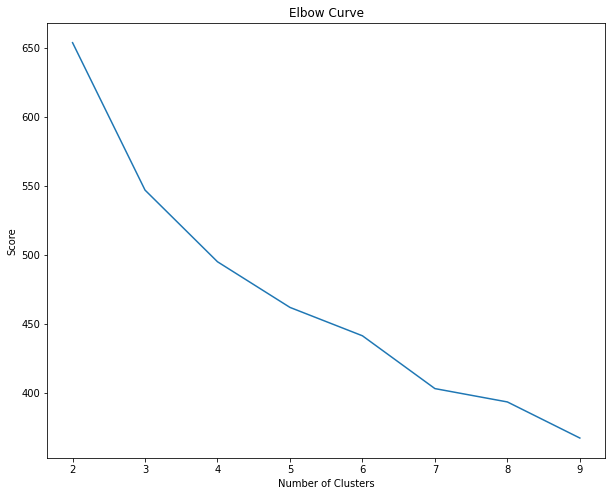

In [97]:
from pyspark.ml.clustering import KMeans

import numpy as np
import pandas as pd

cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('featureVector')
    model = kmeans.fit(X)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [98]:
# Ideal K size is K = 5
# Since the song list is huge, take K = 20
kmeans = KMeans().setK(20)

kmeans.setSeed(1).setFeaturesCol('featureVector')
model = kmeans.fit(X)
model.setPredictionCol("cluster")

transformed = model.transform(historical_songs_df)
transformed.select(["Title","Artist","cluster"]).show(truncate=False)

+-----------------------------------+--------------------------------------------+-------+
|Title                              |Artist                                      |cluster|
+-----------------------------------+--------------------------------------------+-------+
|loco contigo                       |DJ Snake - J Balvin - Tyga                  |0      |
|perfect                            |Logic                                       |10     |
|spirit - from disneys the lion king|BeyoncÃ©                                    |9      |
|amorfoda                           |Bad Bunny                                   |15     |
|whoa                               |XXXTENTACION                                |1      |
|who dat boy                        |Tyler, The Creator - A$AP Rocky             |2      |
|goosebumps                         |Travis Scott                                |10     |
|christmas time                     |Backstreet Boys                             |2      |

### Create a Method to pull song in the same cluster, displayed by highest popularity

In [134]:
def print_similar_songs(query,display=5):
    query = query.lower()
    found_cluster = None
    try:
        found_cluster = transformed.filter(transformed['Title']==query).select(["cluster"]).head(1)[0].__getitem__('cluster')
    except:
        print("Song do not exists in Database for Suggestion")
        return
    
    print(f"Found on Cluster {found_cluster}")
    related_song = transformed.filter(transformed['cluster']==found_cluster).select(["Title", "Popularity", "Uri"])
    related_song = related_song.withColumn("Title", initcap(col('Title'))).withColumn("Title", initcap(col('Title'))).withColumnRenamed("Uri", "Link")
    related_song = related_song.withColumn("Link", concat(lit("https://open.spotify.com/track/"),col('Link')))
    related_song = related_song.orderBy(desc("Popularity")).take(display)
    for song in related_song:
            print(f"{song['Title']} - Listen @ {song['Link']} - Popularity {song['Popularity']}")
    

### Enter the Song Name to get related Songs Suggestion

In [135]:
# Put a Track Name here to get Suggestion.
print_similar_songs("All of me")

Found on Cluster 3
Lovely - Listen @ https://open.spotify.com/track/https://open.spotify.com/track/0u2P5u6lvoDfwTYjAADbn4 - Popularity 79693.9
When The Partys Over - Listen @ https://open.spotify.com/track/https://open.spotify.com/track/43zdsphuZLzwA9k4DJhU0I - Popularity 57236.95
When The Partys Over - Listen @ https://open.spotify.com/track/https://open.spotify.com/track/14JzyD6FlBD5z0wV5P07YI - Popularity 26340.3
I Love You - Listen @ https://open.spotify.com/track/https://open.spotify.com/track/6CcJMwBtXByIz4zQLzFkKc - Popularity 18010.15
Its Beginning To Look A Lot Like Christmas - Listen @ https://open.spotify.com/track/https://open.spotify.com/track/0lLdorYw7lVrJydTINhWdI - Popularity 13829.1


### Related Song Suggestion for the Main Artist's Song which has been on the Top Charts

In [137]:
for artist,artist_id in main_artist_dict.items():
    top_tracks = top_tracks_main_artist.filter(top_tracks_main_artist["artist_id"]==artist_id)
    song_on_the_chart = top_tracks.join(spotify_top_charts_22_cleaned,top_tracks.id ==  spotify_top_charts_22_cleaned.uri,"inner")
    song_on_the_chart = song_on_the_chart.select(["track_name", "energy","artist_id", "artist_names", "weeks_on_chart"]).sort("weeks_on_chart")
    print(f"\nSong which has been in the maximum in the top charts is for - {artist} is : {song_on_the_chart.tail(1)[0].__getitem__('track_name')}")
    if song_on_the_chart.tail(1)[0].__getitem__('track_name'):
        print_similar_songs(song_on_the_chart.tail(1)[0].__getitem__('track_name'))


Song which has been in the maximum in the top charts is for - OneRepublic is : I Ain't Worried
Song do not exists in Database for Suggestion

Song which has been in the maximum in the top charts is for - Harry Styles is : Watermelon Sugar
Found on Cluster 16
Blinding Lights - Listen @ https://open.spotify.com/track/https://open.spotify.com/track/0VjIjW4GlUZAMYd2vXMi3b - Popularity 57327.4
Watermelon Sugar - Listen @ https://open.spotify.com/track/https://open.spotify.com/track/6UelLqGlWMcVH1E5c4H7lY - Popularity 53686.25
Thunder - Listen @ https://open.spotify.com/track/https://open.spotify.com/track/0tKcYR2II1VCQWT79i5NrW - Popularity 40887.35
Nice For What - Listen @ https://open.spotify.com/track/https://open.spotify.com/track/1cTZMwcBJT0Ka3UJPXOeeN - Popularity 34945.7
Nice For What - Listen @ https://open.spotify.com/track/https://open.spotify.com/track/3CA9pLiwRIGtUBiMjbZmRw - Popularity 27828.8

Song which has been in the maximum in the top charts is for - The Weeknd is : Blind

<a id='2.5'></a>
## 2.5 Goal 5: Artist Feature Collaboration Network Beyond Related Artist List Using Graphframes

In [138]:
all_up_collaborations = (spark.read
            .option("header","true")
            .option("inferSchema","true")
            .csv("artist_computed_collaboration.csv"))

artist_info = (spark.read
                  .option("header","true")
                  .option("inferSchema","true") 
                  .csv("artist_info.csv"))

In [139]:
from pyspark.sql.functions import col
from pyspark.sql.functions import count,avg,desc,asc,col

from graphframes import GraphFrame

# create vertices
# vertices = artist_info.withColumnRenamed("name","id")
vertices = artist_info.withColumnRenamed("artist_id","id")

# create edges dataframe with
edge = all_up_collaborations\
.withColumnRenamed("m_art_id", "src")\
.withColumnRenamed("f_art_id", "dst")\

# ceates the graph
g = GraphFrame(vertices, edge)

# graph processing requires recursive/iterative calculations so is a good practice to cache
g.cache()

## Take a look at the DataFrames
g.vertices.show()
g.edges.show()

## Check the number of edges of each vertex
g.degrees.show(truncate=False)

+--------------------+--------------------+---------+----------+--------------------+
|                  id|                name|followers|popularity|              genres|
+--------------------+--------------------+---------+----------+--------------------+
|48WvrUGoijadXXCsG...|           Byklubben|     1738|        24|['nordic house', ...|
|4lDiJcOJ2GLCK6p9q...|            Kontra K|  1999676|        72|['christlicher ra...|
|652XIvIBNGg3C0KIG...|               Maxim|    34596|        36|                  []|
|3dXC1YPbnQPsfHPVk...|  Christopher Martin|   249233|        52|['dancehall', 'lo...|
|74terC9ol9zMo8rfz...|       Jakob Hellman|    21193|        39|['classic swedish...|
|0FQMb3mVrAKlyU4H5...|                Madh|    26677|        19|                  []|
|71BhXa24Zf5zcikUb...|               Juice|    11312|        37|['swedish drill',...|
|3TG1RXLaEhHz5SIPM...|              Nehuda|    36252|        31|       ['francoton']|
|7MFvm8pwjLdmVBZdd...|         VovaZiLvova|    14619| 

+----------------------+------+
|id                    |degree|
+----------------------+------+
|6FXVn5ib6pVL8VZ9Z1L20x|2     |
|0jfo4K7lhf6pWZjQsVtcFF|17    |
|25wMXkplvEHJpJHX8A6Ved|26    |
|23BcnILXgG8UKUS4R48rCv|1     |
|5nLYd9ST4Cnwy6NHaCxbj8|82    |
|1YMrqJ1if4wmBE8CxnqLLt|54    |
|6MmRTVIPIe35OsFqWgRKQJ|32    |
|4xliXgK3ifxzOgSkmngR7v|2     |
|7a301tm0FXInlq1aOB8Gkd|2     |
|2sN4fSzAm2rAL0HIurPCEM|26    |
|4usBxmpmHRVy92QbcWk0M7|18    |
|4LKB1IkCINDDjEX8iS7glI|29    |
|0O6y1pr1YIKq65c6N3sI9c|21    |
|320TrJub4arztwXRm7kqVO|2     |
|5MO2kbaGGA2a8kL4c9qqHq|32    |
|0RTMam5YYSwu91eFhmHYV8|1     |
|5kUdDGYwca4e4Ijwsze0XO|1     |
|30QM66iEYigRKQfRNtnx7t|1     |
|0oW137oXCLwA5b4uYRxvIn|34    |
|5M9fdo6QZDwcUj08IvyLU0|1     |
+----------------------+------+
only showing top 20 rows



### Degree Centrality Analysis

We want to understand the importance of a node, in our case our main 5 artists based on the collaborations they have been in, either as a main performer ( man artist collaborated with other artists) or as a collaborator ( other artist collaborated with main artist)

In [140]:
total_degree = g.degrees
in_degree = g.inDegrees
out_degree = g.outDegrees


all_degrees = (total_degree.join(in_degree, "id", how="left")
.join(out_degree, "id", how="left")
.fillna(0)
.sort("degree", ascending=False))

all_degrees = all_degrees.withColumnRenamed("degree", "All Collaboration")\
    .withColumnRenamed("inDegree", f"Main Artist collborated W O Artist")\
    .withColumnRenamed("outDegree", f"O Artist collaborated W Main Artist")

# Save the Information
all_degrees.show()
all_degrees.toPandas().to_csv('collboration_degree.csv', index=False)

+--------------------+-----------------+----------------------------------+-----------------------------------+
|                  id|All Collaboration|Main Artist collborated W O Artist|O Artist collaborated W Main Artist|
+--------------------+-----------------+----------------------------------+-----------------------------------+
|5aIqB5nVVvmFsvSdE...|             1781|                              1321|                                460|
|1U5zgr455OGyIkLNX...|             1371|                               259|                               1112|
|0f1IECbrVV952unZk...|              858|                                89|                                769|
|4hV3aU0WKvFaiX5ug...|              633|                               384|                                249|
|7jzR5qj8vFnSu5JHa...|              580|                               557|                                 23|
|0SfsnGyD8FpIN4U4W...|              513|                                28|                             

### Show collaboration stats for main artist

In [141]:
for artist,artist_id in main_artist_dict.items():
    print(f"Collaboration for {artist}")
    selected_artist_degree = all_degrees.filter(all_degrees["id"]==artist_id)
    selected_artist_degree.show()

Collaboration for OneRepublic
+--------------------+-----------------+----------------------------------+-----------------------------------+
|                  id|All Collaboration|Main Artist collborated W O Artist|O Artist collaborated W Main Artist|
+--------------------+-----------------+----------------------------------+-----------------------------------+
|5Pwc4xIPtQLFEnJri...|               38|                                28|                                 10|
+--------------------+-----------------+----------------------------------+-----------------------------------+

Collaboration for Harry Styles
+---+-----------------+----------------------------------+-----------------------------------+
| id|All Collaboration|Main Artist collborated W O Artist|O Artist collaborated W Main Artist|
+---+-----------------+----------------------------------+-----------------------------------+
+---+-----------------+----------------------------------+-----------------------------------

### Is main artist is part of the top 20 collaborators.

None of our main artist is actually part of the top collaborator list

In [142]:
# sorted by all all collaboration, take first 20 artist only.
print("Display Top 20 Collaboration")

top_20_degrees = all_degrees.limit(20)
top_20_degrees.show()

arist_id_list =  list(main_artist_dict.values())
selected_main_artist_degree = top_20_degrees.filter(top_20_degrees["id"].isin(artist_id))
selected_main_artist_degree.show()

Display Top 20 Collaboration


+--------------------+-----------------+----------------------------------+-----------------------------------+
|                  id|All Collaboration|Main Artist collborated W O Artist|O Artist collaborated W Main Artist|
+--------------------+-----------------+----------------------------------+-----------------------------------+
|5aIqB5nVVvmFsvSdE...|             1781|                              1321|                                460|
|1U5zgr455OGyIkLNX...|             1371|                               259|                               1112|
|0f1IECbrVV952unZk...|              858|                                89|                                769|
|4hV3aU0WKvFaiX5ug...|              633|                               384|                                249|
|7jzR5qj8vFnSu5JHa...|              580|                               557|                                 23|
|0SfsnGyD8FpIN4U4W...|              513|                                28|                             

+---+-----------------+----------------------------------+-----------------------------------+
| id|All Collaboration|Main Artist collborated W O Artist|O Artist collaborated W Main Artist|
+---+-----------------+----------------------------------+-----------------------------------+
+---+-----------------+----------------------------------+-----------------------------------+



### Triplets - GraphFrame
### Find If Main Artist has collaborated with Other Artist as - Lead Artist or Featuring Artist

Now we are going to develop a triplet filter in order to understand the extended network of collaborators of our main artists  n this case the src or dst will have any of our 5 top artists and the edge gives us the collaboration. Then we filter by src and dst and joined them, to find all collaboration as main artist or as featuring artist for our main 5 artist. With that we can understand which pairs have a strong history of 2 ways collaboration that have brought significantly benefits in terms of popularity ans an alternative to the recommeded artist we have found in our previous analysis

In [143]:
triplets = g.triplets
triplets.printSchema()

# filter triplets
for artist,artist_id in main_artist_dict.items():
    print(f"Collaboration for {artist}")
    
    main_artist_in_src = triplets.filter(triplets["src.id"]==artist_id)
    print(main_artist_in_src.count())
    main_artist_in_dst = triplets.filter(triplets["dst.id"]==artist_id)
    print(main_artist_in_dst.count())


    main_artist_in_src = main_artist_in_src.select(col("src.id").alias("main_artist_id"), col("src.name").alias("main_artist_name"), col("dst.id").alias("ft_artist"), col("dst.name").alias("ft_artist_name"), "edge.collab_followers","edge.collab_popularity")
    main_artist_in_dst = main_artist_in_dst.select(col("dst.id").alias("main_artist_id"),col("dst.name").alias("main_artist_name"), col("src.id").alias("ft_artist"), col("src.name").alias("ft_artist_name"), "edge.collab_followers","edge.collab_popularity")

    all_collaboration = main_artist_in_src.union(main_artist_in_dst)
    print(all_collaboration.count())
    
    
    # sort by popularity collaboration
    all_collaboration = all_collaboration.sort(all_collaboration.collab_popularity.desc())
    
    
    all_collaboration.select("main_artist_name","ft_artist_name","collab_followers","collab_popularity").show(5)
    #all_collaboration.toPandas().to_csv(f"graph/all_collaboration_{artist}.csv", index=False)

root
 |-- src: struct (nullable = false)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- followers: string (nullable = true)
 |    |-- popularity: integer (nullable = true)
 |    |-- genres: string (nullable = true)
 |-- edge: struct (nullable = false)
 |    |-- src: string (nullable = true)
 |    |-- m_art_name: string (nullable = true)
 |    |-- dst: string (nullable = true)
 |    |-- f_art_name: string (nullable = true)
 |    |-- f_art_followers: string (nullable = true)
 |    |-- f_art_popularity: integer (nullable = true)
 |    |-- artist_id: string (nullable = true)
 |    |-- m_art_followers: string (nullable = true)
 |    |-- m_art_popularity: integer (nullable = true)
 |    |-- collab_followers: double (nullable = true)
 |    |-- collab_popularity: double (nullable = true)
 |-- dst: struct (nullable = false)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- followers: string (nullable = true)
 |  

### PageRank

We are going to run a Personalized PageRank (PPR) for the Weeknd. PPR is an algorithm that calculates he importance of nodes in a graph from the perspective of a specific node. As we can see, excluding himself, according to PageRank the artist The Weeknd should be paired with are TY Dollar, Snoop Dog and Eminem ( in the first 3 positions)

In [144]:
main_artist = "1Xyo4u8uXC1ZmMpatF05PJ"
pagerank_result = g.pageRank(resetProbability=0.15, maxIter=20, sourceId=main_artist)
pr=pagerank_result.vertices.sort("pagerank", ascending=False).show()

+--------------------+------------------+---------+----------+--------------------+--------------------+
|                  id|              name|followers|popularity|              genres|            pagerank|
+--------------------+------------------+---------+----------+--------------------+--------------------+
|1Xyo4u8uXC1ZmMpat...|        The Weeknd| 49387909|        93|['canadian contem...| 0.31392551823017356|
|7c0XG5cIJTrrAgEC3...|     Ty Dolla $ign|  4339428|        81|['dance pop', 'hi...|0.015168063449135377|
|7hJcb9fa4alzcOq3E...|        Snoop Dogg|  8686870|        84|['g funk', 'gangs...|0.009882947446752022|
|7dGJo4pcD2V6oG8kP...|            Eminem| 59184634|        90|['detroit hip hop...|0.007972771573939448|
|7sfl4Xt5KmfyDs2T3...|           Lil Jon|  1332939|        73|['atl hip hop', '...|0.007625623197182064|
|6vXTefBL93Dj5IqAW...|    French Montana|  4648251|        76|['gangster rap', ...|0.007248627701970...|
|738wLrAtLtCtFOLvQ...|       Major Lazer|  6302403|    

<a id='3'></a>
# 3. Storing Results in MariaDB

In [149]:
url = "jdbc:mysql://localhost:3306/GROUPA"
table = "MAIN_ARTIST"
mode = "overwrite"
props = {"user":"osbdet",
        "password":"osbdet123$", 
        "driver":"org.mariadb.jdbc.Driver"}

In [150]:
main_artist_df.printSchema()

root
 |-- images: string (nullable = true)
 |-- followers: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- name: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- artist_id: string (nullable = true)



In [151]:
main_artist_df.write.jdbc(url,table,mode,props)

In [152]:
url = "jdbc:mysql://localhost:3306/GROUPA"
table = "TOP_TRACKS_MAIN_ARTIST"
mode = "overwrite"
props = {"user":"osbdet",
        "password":"osbdet123$", 
        "driver":"org.mariadb.jdbc.Driver"}

In [153]:
top_tracks_main_artist.printSchema()

root
 |-- duration_ms: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- artists_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- artists_name: string (nullable = true)
 |-- id: string (nullable = true)
 |-- artist_id: string (nullable = true)



In [154]:
url = "jdbc:mysql://localhost:3306/GROUPA"
table = "SPOTIFY_TOP_CHARTS_22"
mode = "overwrite"
props = {"user":"osbdet",
        "password":"osbdet123$", 
        "driver":"org.mariadb.jdbc.Driver"}

In [155]:
spotify_top_charts_22.printSchema()

root
 |-- uri: string (nullable = true)
 |-- artist_names: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- peak_rank: integer (nullable = true)
 |-- weeks_on_chart: integer (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: integer (nullable = true)
 |-- duration_ms: integer (nullable = true)



In [156]:
url = "jdbc:mysql://localhost:3306/GROUPA"
table = "COLLBORATION_GROUPED"
mode = "overwrite"
props = {"user":"osbdet",
        "password":"osbdet123$", 
        "driver":"org.mariadb.jdbc.Driver"}

In [157]:
mariadb_collboration_grouped_df = spotify_top_charts_22_main_artist_collaboration
mariadb_collboration_grouped_df.printSchema()

root
 |-- uri: string (nullable = true)
 |-- artist_names: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- peak_rank: integer (nullable = true)
 |-- weeks_on_chart: integer (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: integer (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- main_artist: string (nullable = true)
 |-- collaboration: boolean (nullable = false)



In [158]:
url = "jdbc:mysql://localhost:3306/GROUPA"
table = "POPULAR_SCORE_RELATED_ARTIST"
mode = "overwrite"
props = {"user":"osbdet",
        "password":"osbdet123$", 
        "driver":"org.mariadb.jdbc.Driver"}

In [159]:
sparkDF=spark.createDataFrame(popular_score_related_artist) 
mariadb_popular_score_related_artist = sparkDF
mariadb_popular_score_related_artist.printSchema()

root
 |-- name: string (nullable = true)
 |-- total_tweet: long (nullable = true)
 |-- trend: long (nullable = true)
 |-- followers: string (nullable = true)



In [160]:
mariadb_popular_score_related_artist.write.jdbc(url,table,mode,props)

In [161]:
url = "jdbc:mysql://localhost:3306/GROUPA"
table = "RELATED_ARTIST"
mode = "overwrite"
props = {"user":"osbdet",
        "password":"osbdet123$", 
        "driver":"org.mariadb.jdbc.Driver"}

In [162]:
mariadb_related_artist_main_artist = related_artist_main_artist
mariadb_related_artist_main_artist.printSchema()

root
 |-- images: string (nullable = true)
 |-- followers: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- name: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- id: string (nullable = true)
 |-- artist_id: string (nullable = true)



In [163]:
mariadb_related_artist_main_artist.write.jdbc(url,table,mode,props)

In [164]:
mariadb_consolidated_tweet_df = consolidated_tweet_df
mariadb_consolidated_tweet_df.printSchema()
url = "jdbc:mysql://localhost:3306/GROUPA"
table = "TABLEA"
mode = "overwrite"
props = {"user":"osbdet",
        "password":"osbdet123$", 
        "driver":"org.mariadb.jdbc.Driver"}

root
 |-- end: timestamp (nullable = true)
 |-- start: timestamp (nullable = true)
 |-- tweet_count: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- artist_id: string (nullable = true)



In [165]:
mariadb_tablea = spotify_top_charts_22_main_artist_.groupBy("main_artist")\
    .agg(count("*").alias("Total Song on Top Chart"), avg("weeks_on_chart").alias("Average Week on Top Charts"))\
.withColumnRenamed("main_artist","Artist")

In [166]:
mariadb_tablea.write.jdbc(url,table,mode,props)

In [167]:
url = "jdbc:mysql://localhost:3306/GROUPA"
table = "MAIN_ARTIST_TWEET"
mode = "overwrite"
props = {"user":"osbdet",
        "password":"osbdet123$", 
        "driver":"org.mariadb.jdbc.Driver"}

In [168]:
sparkDF1=spark.createDataFrame(main_artist_tweet_count_df) 
mariadb_popular_score_related_artist = sparkDF1
mariadb_popular_score_related_artist.printSchema()

root
 |-- images: string (nullable = true)
 |-- followers: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- name: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- tweets_last_month: long (nullable = true)



In [169]:
mariadb_popular_score_related_artist.write.jdbc(url,table,mode,props)

In [170]:
url = "jdbc:mysql://localhost:3306/GROUPA"
table = "PAGERANK_TWEET"
mode = "overwrite"
props = {"user":"osbdet",
        "password":"osbdet123$", 
        "driver":"org.mariadb.jdbc.Driver"}

In [171]:
print(pr)
# mariadb_pagerank=pr
# mariadb_pagerank.printSchema()

None


<a id='4'></a>
# 4. Supplementary Analysis - Historical song information last 20 year


### A. What are the genre with highest popularity in the last 20 years?
### B. What are the artist with the most songs in the last 20 years?
### C How did the length of a song change over the last 20 years? 
### D. How did the number of songs relate to the popularity
### E. Based on music feeatures what clusters can we find? 
### F. Can we find a model to predict popularity of a song based on music attributes? 

### Preparation

In [172]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [173]:
import findspark
findspark.init()

In [174]:
import findspark
findspark.init()
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, split

In [175]:
from pyspark.sql.session import SparkSession

spark = (SparkSession.builder
    .appName("Spotify_last_20_years")
    .getOrCreate())

In [176]:
df_20 = (spark.read
            .option("header","true")
            .option("inferSchema","true")
            .csv("hits_last_20_years.csv")            
            .distinct())

In [177]:
df_20.head()

Row(artist='Vengaboys', song='Shalala Lala', duration_ms=214819, explicit=False, year=2000, popularity=58, danceability=0.751, energy=0.901, key=2, loudness=-5.802, mode=1, speechiness=0.0328, acousticness=0.0504, instrumentalness=0.00308, liveness=0.0395, valence=0.973, tempo=124.017, genre='pop')

In [178]:
df_20.columns

['artist',
 'song',
 'duration_ms',
 'explicit',
 'year',
 'popularity',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'genre']

In [179]:
df_20.printSchema()

root
 |-- artist: string (nullable = true)
 |-- song: string (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- year: integer (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- genre: string (nullable = true)



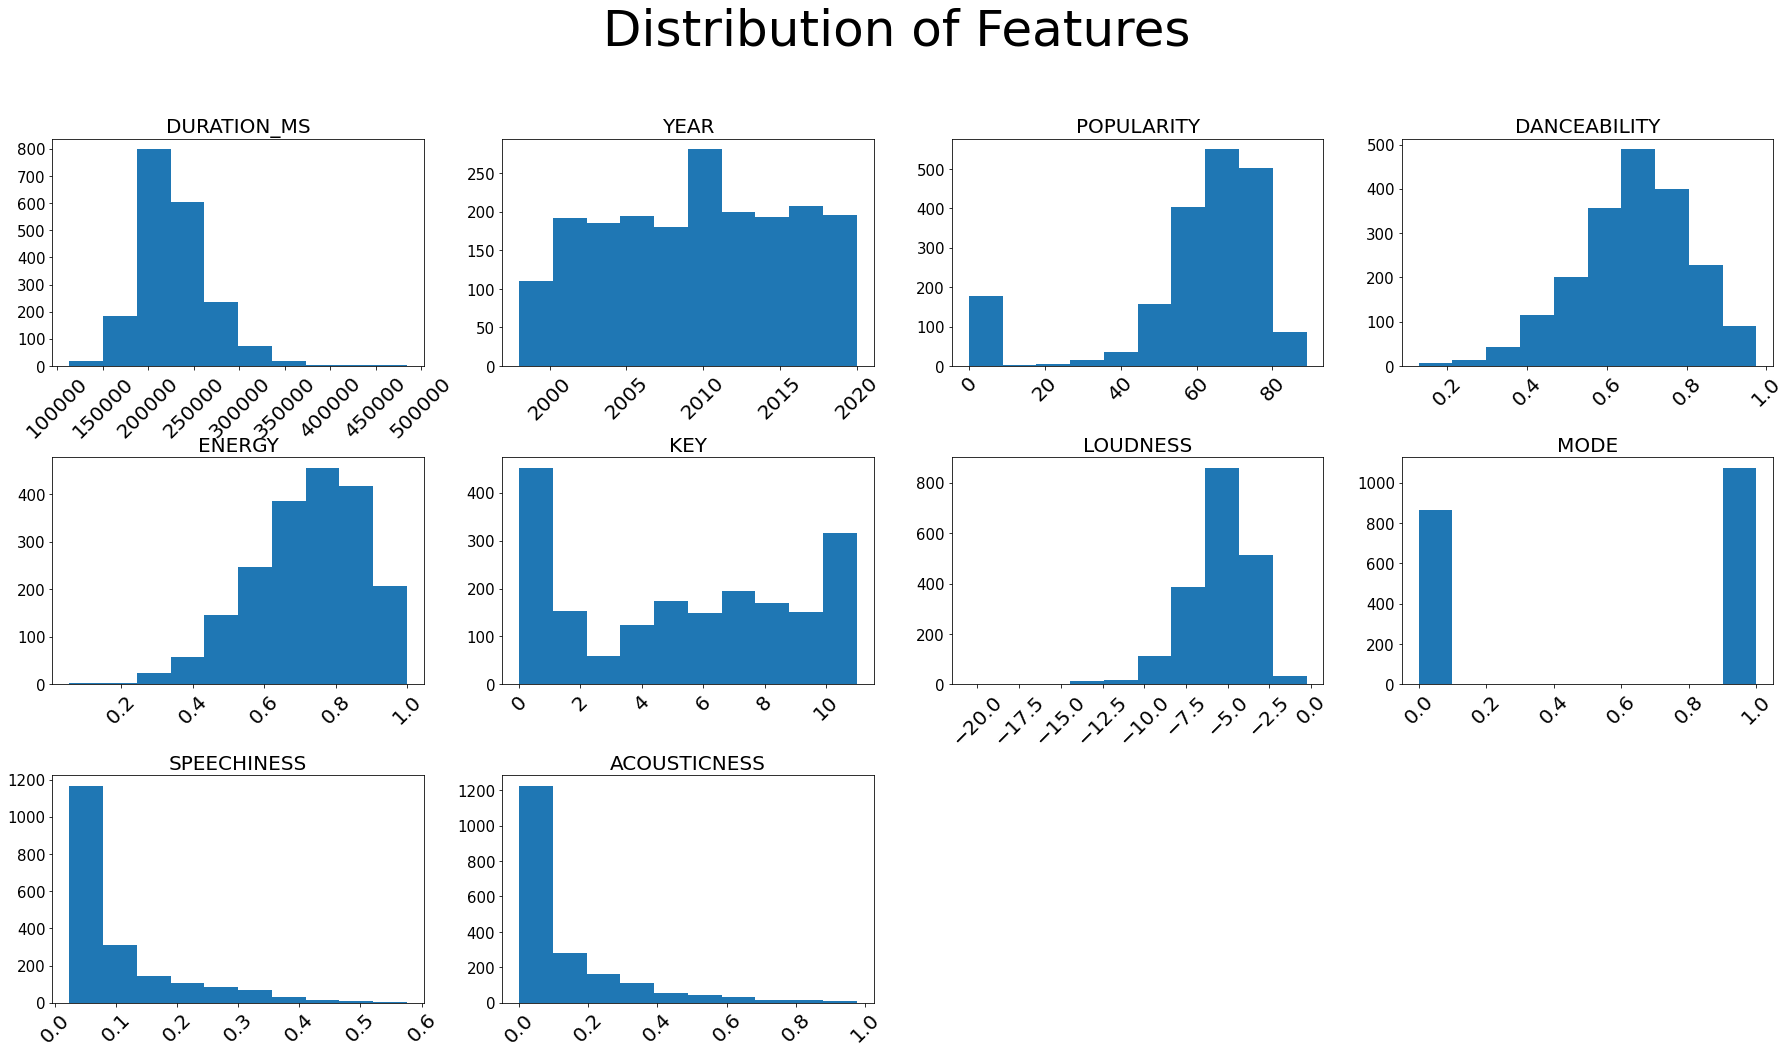

In [180]:
fig = plt.figure(figsize=(25,15))
st = fig.suptitle("Distribution of Features", fontsize=50, verticalalignment="center")
for col, num in zip(df_20.toPandas().describe().columns,range(1,11)):
    ax = fig.add_subplot(3,4, num)
    ax.hist(df_20.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45, fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(), fontsize=20)
    
    
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [181]:
catCols = [x for (x, dataType) in df_20.dtypes if (dataType == "string") or (x=="explicit") or (x=="mode")]
numCols = [x for (x, dataType) in df_20.dtypes if (dataType =="double" or "integer") and (x!= "song") and (x!= "artist") and (x!= "genre") and (x!= "explicit")]

In [182]:
print(df_20)

DataFrame[artist: string, song: string, duration_ms: int, explicit: boolean, year: int, popularity: int, danceability: double, energy: double, key: int, loudness: double, mode: int, speechiness: double, acousticness: double, instrumentalness: double, liveness: double, valence: double, tempo: double, genre: string]


In [183]:
from pyspark.sql.functions import col

In [184]:
df_20 = df_20.withColumn("duration_min", col("duration_ms") / 100000)

In [185]:
numeric_features_df = df_20.select(numCols)
numeric_features_df.toPandas().head()

duration_ms  year  popularity  danceability  energy  key  loudness  mode  \
0       214819  2000          58         0.751   0.901    2    -5.802     1   
1       221133  2001          65         0.730   0.602    6    -3.782     0   
2       216706  2004          70         0.751   0.731    6    -4.419     0   
3       202133  2006          72         0.348   0.875   11    -4.758     0   
4       172053  2010          61         0.752   0.836   10    -3.173     1   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  
0       0.0328        0.0504          0.003080    0.0395    0.973  124.017  
1       0.2060        0.3620          0.000004    0.1690    0.927   97.954  
2       0.0308        0.0838          0.000000    0.0556    0.973   97.007  
3       0.1990        0.0341          0.000000    0.1170    0.407  169.152  
4       0.1150        0.0843          0.000425    0.4240    0.519  120.003

In [186]:
from pyspark.mllib.stat import Statistics
import pandas as pd

In [187]:
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])

corr_mat = Statistics.corr(features,method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index = col_names
corr_df.columns = col_names
round(corr_df,2)

TypeError: Invalid argument, not a string or column:                   duration_ms      year  popularity  danceability    energy  \
duration_ms          1.000000 -0.318835    0.048140     -0.060083 -0.082982   
year                -0.318835  1.000000   -0.007294      0.035444 -0.110265   
popularity           0.048140 -0.007294    1.000000     -0.000143 -0.013404   
danceability        -0.060083  0.035444   -0.000143      1.000000 -0.103204   
energy              -0.082982 -0.110265   -0.013404     -0.103204  1.000000   
key                 -0.001353  0.008588    0.013561      0.035747 -0.000642   
loudness            -0.086226  0.017228    0.030441     -0.035638  0.651986   
mode                -0.004095 -0.007208   -0.019430     -0.068643 -0.044177   
speechiness          0.062538  0.003146    0.021977      0.140955 -0.058225   
acousticness         0.009960  0.040698    0.022501     -0.062374 -0.447056   
instrumentalness    -0.006409 -0.051490   -0.048104      0.021662  0.040662   
liveness             0.022549 -0.026418   -0.010291     -0.127349  0.153922   
valence             -0.116423 -0.208410   -0.011012      0.403787  0.331756   
tempo               -0.033762  0.077798    0.011057     -0.169074  0.152305   

                       key  loudness      mode  speechiness  acousticness  \
duration_ms      -0.001353 -0.086226 -0.004095     0.062538      0.009960   
year              0.008588  0.017228 -0.007208     0.003146      0.040698   
popularity        0.013561  0.030441 -0.019430     0.021977      0.022501   
danceability      0.035747 -0.035638 -0.068643     0.140955     -0.062374   
energy           -0.000642  0.651986 -0.044177    -0.058225     -0.447056   
key               1.000000 -0.005229 -0.153319     0.003769      0.000719   
loudness         -0.005229  1.000000 -0.027568    -0.081831     -0.312079   
mode             -0.153319 -0.027568  1.000000     0.002192      0.009210   
speechiness       0.003769 -0.081831  0.002192     1.000000      0.002926   
acousticness      0.000719 -0.312079  0.009210     0.002926      1.000000   
instrumentalness -0.004053 -0.103575 -0.036433    -0.062401     -0.003220   
liveness         -0.040827  0.101972  0.028334     0.056532     -0.107766   
valence           0.035441  0.228250 -0.080279     0.069247     -0.126129   
tempo            -0.009852  0.081655  0.047445     0.063192     -0.105533   

                  instrumentalness  liveness   valence     tempo  
duration_ms              -0.006409  0.022549 -0.116423 -0.033762  
year                     -0.051490 -0.026418 -0.208410  0.077798  
popularity               -0.048104 -0.010291 -0.011012  0.011057  
danceability              0.021662 -0.127349  0.403787 -0.169074  
energy                    0.040662  0.153922  0.331756  0.152305  
key                      -0.004053 -0.040827  0.035441 -0.009852  
loudness                 -0.103575  0.101972  0.228250  0.081655  
mode                     -0.036433  0.028334 -0.080279  0.047445  
speechiness              -0.062401  0.056532  0.069247  0.063192  
acousticness             -0.003220 -0.107766 -0.126129 -0.105533  
instrumentalness          1.000000 -0.034818 -0.010660  0.035442  
liveness                 -0.034818  1.000000  0.014737  0.027449  
valence                  -0.010660  0.014737  1.000000 -0.023973  
tempo                     0.035442  0.027449 -0.023973  1.000000   of type <class 'pandas.core.frame.DataFrame'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.

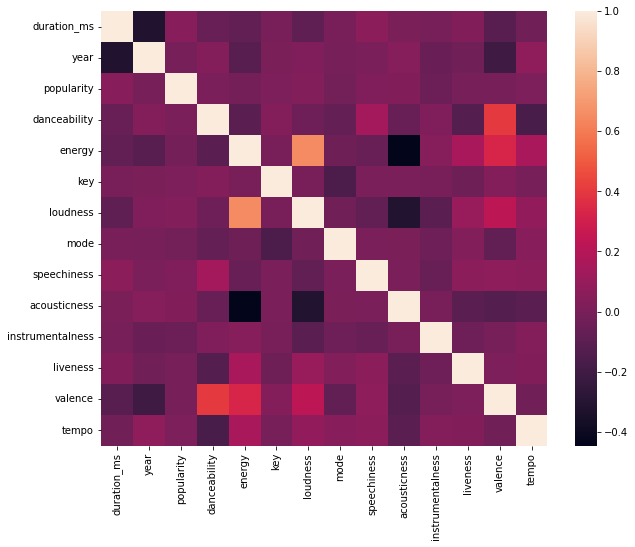

In [189]:
sns.heatmap(corr_df);

### A. What are the genre with highest popularity in the last 20 years?

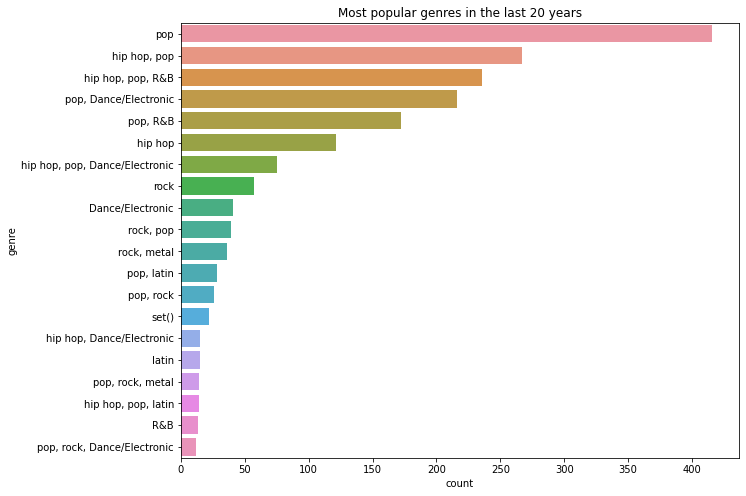

In [190]:

result_df = (df_20.groupBy("genre")
               .count()
               .orderBy("count", ascending=False)
               .limit(20)
               .toPandas()
            )


sns.barplot(data=result_df, y='genre', x='count').set_title('Most popular genres in the last 20 years');

However we see here that some genres are overlapping

In [191]:
genreexp = df_20.withColumn("genre", split(df_20.genre, ', ')).toPandas().explode('genre').reset_index(drop=True)  
genreexp

artist                                                  song  \
0            Vengaboys                                          Shalala Lala   
1      Destiny's Child                              Independent Women, Pt. 1   
2      Destiny's Child                              Independent Women, Pt. 1   
3               Juanes                                       La Camisa Negra   
4               Juanes                                       La Camisa Negra   
...                ...                                                   ...   
3583         Lil Wayne                                              Lollipop   
3584        Otto Knows                           Million Voices - Radio Edit   
3585        Otto Knows                           Million Voices - Radio Edit   
3586      Fall Out Boy  My Songs Know What You Did In The Dark (Light Em Up)   
3587  Young T & Bugsey                           Strike a Pose (feat. Aitch)   

      duration_ms  explicit  year  popularity  danceability  energy  key  \
0          214819     False  2000          58         0.751   0.901    2   
1          221133     False  2001          65         0.730   0.602    6   
2          221133     False  2001          65         0.730   0.602    6   
3          216706     False  2004          70         0.751   0.731    6   
4          216706     False  2004          70         0.751   0.731    6   
...           ...       ...   ...         ...           ...     ...  ...   
3583       299333      True  2008          69         0.829   0.428    0   
3584       192866     False  2012           0         0.582   0.894    8   
3585       192866     False  2012           0         0.582   0.894    8   
3586       186826     False  2013          71         0.558   0.924    9   
3587       214203      True  2019          61         0.531   0.581    1   

      loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0       -5.802     1       0.0328        0.0504          0.003080    0.0395   
1       -3.782     0       0.2060        0.3620          0.000004    0.1690   
2       -3.782     0       0.2060        0.3620          0.000004    0.1690   
3       -4.419     0       0.0308        0.0838          0.000000    0.0556   
4       -4.419     0       0.0308        0.0838          0.000000    0.0556   
...        ...   ...          ...           ...               ...       ...   
3583    -9.469     1       0.0831        0.0560          0.004130    0.1370   
3584    -6.298     1       0.0410        0.0022          0.022300    0.0664   
3585    -6.298     1       0.0410        0.0022          0.022300    0.0664   
3586    -4.341     0       0.0640        0.0271          0.000003    0.5370   
3587    -5.801     1       0.1010        0.0107          0.000016    0.1010   

      valence    tempo             genre  duration_min  
0      0.9730  124.017               pop       2.14819  
1      0.9270   97.954               pop       2.21133  
2      0.9270   97.954               R&B       2.21133  
3      0.9730   97.007               pop       2.16706  
4      0.9730   97.007             latin       2.16706  
...       ...      ...               ...           ...  
3583   0.4500  148.075               pop       2.99333  
3584   0.0694  125.946               pop       1.92866  
3585   0.0694  125.946  Dance/Electronic       1.92866  
3586   0.5670  151.990              rock       1.86826  
3587   0.5910  137.776           hip hop       2.14203  

[3588 rows x 19 columns]

In [192]:
songsbyartist_df = df_20.groupBy('artist').count()
popularity_byartist_df = df_20.groupBy('artist').mean().select('artist','avg(popularity)')
songspopbyartist_df = songsbyartist_df.join(popularity_byartist_df,'artist','inner')

In [193]:
popularity_byartist_df

DataFrame[artist: string, avg(popularity): double]

In [194]:
songspopbyartist_df

DataFrame[artist: string, count: bigint, avg(popularity): double]

In [195]:
genreexp.genre.unique()

array(['pop', 'R&B', 'latin', 'rock', 'Dance/Electronic', 'metal',
       'set()', 'hip hop', 'Folk/Acoustic', 'easy listening', 'jazz',
       'World/Traditional', 'country', 'blues', 'classical'], dtype=object)

In [196]:

genreexp.drop(genreexp[genreexp.genre.isin(['set()'])].index,inplace=True)


avgbygenre = genreexp.groupby('genre').mean().reset_index()
avgbygenre.drop(['year'],axis=1,inplace=True)
avgbygenre

genre    duration_ms  explicit  popularity  danceability  \
0    Dance/Electronic  216043.823684  0.115789   54.610526      0.667637   
1       Folk/Acoustic  220183.650000  0.050000   60.200000      0.567400   
2                 R&B  239582.967963  0.283753   58.569794      0.689686   
3   World/Traditional  219063.800000  0.100000   53.800000      0.603000   
4               blues  244643.250000  0.000000   45.500000      0.649750   
5           classical  219560.000000  0.000000   63.000000      0.590000   
6             country  222198.700000  0.050000   56.200000      0.576750   
7      easy listening  234931.000000  0.000000   61.428571      0.612000   
8             hip hop  233989.757656  0.552597   61.834887      0.718383   
9                jazz  224813.000000  0.000000   57.500000      0.548000   
10              latin  227494.682540  0.095238   58.952381      0.725063   
11              metal  234249.218750  0.140625   67.671875      0.508281   
12                pop  228470.070164  0.251580   59.039823      0.670872   
13               rock  227571.444444  0.088889   62.626667      0.555938   

      energy        key   loudness      mode  speechiness  acousticness  \
0   0.768458   5.731579  -5.143868  0.507895     0.078725      0.107887   
1   0.728550   4.600000  -6.353800  0.750000     0.042185      0.197199   
2   0.662096   5.322654  -5.933579  0.519451     0.114744      0.151053   
3   0.685700   3.900000  -6.187800  0.600000     0.079530      0.272961   
4   0.669750   4.250000  -5.616500  0.500000     0.091900      0.021053   
5   0.578000  10.000000  -5.798000  0.000000     0.052800      0.612000   
6   0.729650   5.950000  -5.517100  0.800000     0.060755      0.213051   
7   0.689714   6.857143  -7.598714  0.428571     0.051457      0.240632   
8   0.699891   5.593875  -5.611569  0.541944     0.151975      0.116415   
9   0.233000   2.000000 -14.418000  1.000000     0.031700      0.686000   
10  0.789016   5.476190  -4.685508  0.587302     0.095095      0.151821   
11  0.831172   5.125000  -4.854937  0.625000     0.047275      0.040575   
12  0.715886   5.350190  -5.521795  0.548040     0.100703      0.131701   
13  0.790596   5.226667  -5.151111  0.631111     0.059479      0.073963   

    instrumentalness  liveness   valence       tempo  duration_min  
0           0.038381  0.184883  0.538031  124.020800      2.160438  
1           0.043269  0.188910  0.579250  110.348050      2.201836  
2           0.006649  0.163768  0.564274  115.705721      2.395830  
3           0.198378  0.194410  0.653700  110.333200      2.190638  
4           0.112260  0.171200  0.495500  122.932250      2.446433  
5           0.000162  0.083700  0.264000   81.663000      2.195600  
6           0.000014  0.180740  0.529550  130.541800      2.221987  
7           0.038343  0.135486  0.570286  121.425714      2.349310  
8           0.006162  0.188884  0.562186  118.056161      2.339898  
9           0.004443  0.109950  0.225000  104.999500      2.248130  
10          0.000660  0.195213  0.691651  118.442063      2.274947  
11          0.005203  0.190177  0.444886  125.206672      2.342492  
12          0.011559  0.180257  0.554763  119.770478      2.284701  
13          0.030360  0.195489  0.526602  126.155267      2.275714

Text(0.5, 0, 'Average popularity')

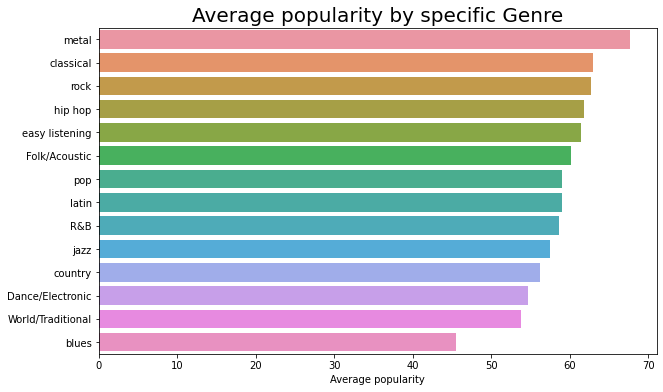

In [197]:
# Popularity by genre
plt.rcParams["figure.figsize"] = (10,6)
ax = sns.barplot(x="popularity", y="genre",
                  data=avgbygenre.sort_values("popularity", ascending=False))
ax.set_title("Average popularity by specific Genre", fontsize=20)
ax.set_ylabel("")
ax.set_xlabel("Average popularity")

### B. What are the artist with the most songs in the last 20 years?

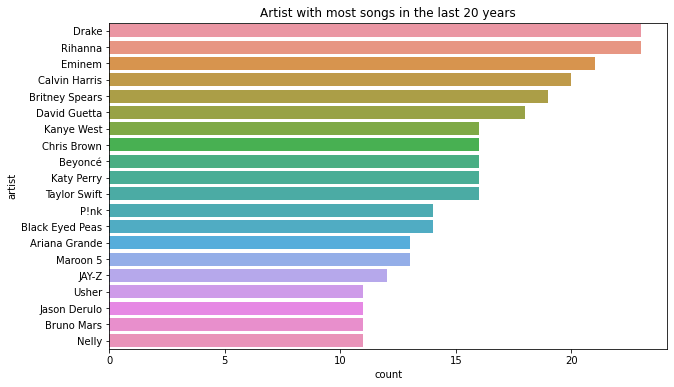

In [198]:
# each count is a song that was in the top 200 most played on a day on spotify during the last 3 years
result_df = (df_20.groupBy("artist")
               .count()
               .orderBy("count", ascending=False)
               .limit(20)
               .toPandas()
            )


sns.barplot(data=result_df, y='artist', x='count').set_title('Artist with most songs in the last 20 years');

### C How did the length of a song change over the last 20 years?

In [199]:
df_20.orderBy(col("duration_min").desc()).select('artist','song','duration_min','year').show(10)

+--------------------+--------------------+------------+----+
|              artist|                song|duration_min|year|
+--------------------+--------------------+------------+----+
|   Justin Timberlake|             Mirrors|     4.84146|2013|
|       Roger Sanchez|      Another Chance|     4.52906|2000|
|   Justin Timberlake|What Goes Around....|     4.48573|2006|
|   Justin Timberlake|LoveStoned / I Th...|     4.44333|2006|
|         Dirty Vegas|          Days Go By|     4.32146|2002|
|          Nio Garcia|     Te Boté - Remix|      4.1792|2018|
|              Eminem|                Stan|     4.04106|2000|
|The Chemical Brot...|           Galvanize|     3.93813|2005|
|         Alicia Keys|You Don't Know My...|     3.66733|2003|
|            Lil' Kim|         Magic Stick|     3.59973|2019|
+--------------------+--------------------+------------+----+
only showing top 10 rows



In [200]:
df_20.orderBy(col("duration_min").asc()).select('artist','song','duration_min','year').show(10)

+------------+--------------+------------+----+
|      artist|          song|duration_min|year|
+------------+--------------+------------+----+
|   Lil Nas X| Old Town Road|        1.13|2019|
|   Lil Nas X|        Panini|     1.14893|2019|
|XXXTENTACION|Jocelyn Flores|     1.19133|2017|
|XXXTENTACION|       changes|     1.21886|2018|
|    Lil Pump|    Gucci Gang|     1.24055|2017|
|    Saweetie|       My Type|     1.26446|2019|
|      The xx|         Intro|      1.2792|2009|
|    Blueface|      Thotiana|     1.29264|2018|
|       Bazzi|          Mine|     1.31064|2018|
|   iann dior|      emotions|     1.31213|2019|
+------------+--------------+------------+----+
only showing top 10 rows



+----+-----+
|year|count|
+----+-----+
|1998|    1|
|1999|   38|
|2000|   71|
|2001|  106|
|2002|   86|
|2003|   91|
|2004|   95|
|2005|  101|
|2006|   93|
|2007|   90|
|2008|   91|
|2009|   82|
|2010|  103|
|2011|   96|
|2012|  113|
|2013|   87|
|2014|  100|
|2015|   93|
|2016|   98|
|2017|  110|
|2018|  104|
|2019|   89|
|2020|    3|
+----+-----+



<AxesSubplot:xlabel='year'>

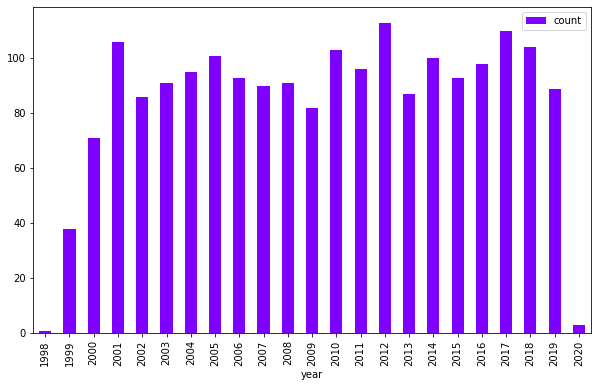

In [201]:
#songs per year
df_by_year = df_20.groupBy(col('year')).count().orderBy('year')
df_by_year.show(30)
df_by_year.toPandas().plot.bar(x='year',cmap='rainbow',figsize=(10,6))

In [202]:
songsbyartist_df = df_20.groupBy(col('artist')).count()
popbyartist_df = df_20.groupBy(col('artist')).mean().select('artist','avg(popularity)')
songspopbyartist_df = songsbyartist_df.join(popbyartist_df,'artist','inner')

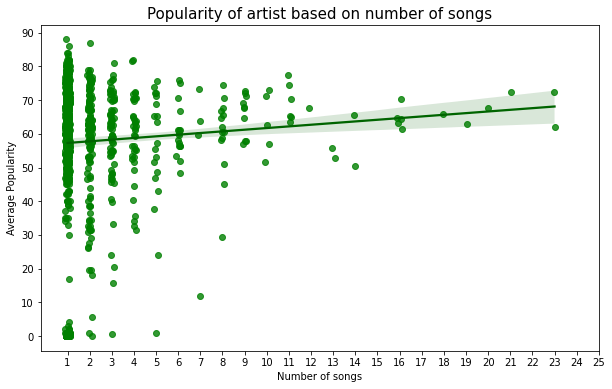

In [203]:
#Popularity based on numer of songs
plt.rcParams["figure.figsize"] = (10,6)
ax = sns.regplot(y="avg(popularity)", x="count", data=songspopbyartist_df.toPandas(),scatter_kws={"color": "green"}, line_kws={"color": "darkgreen"}, x_jitter=0.1)
ax.set_title("Popularity of artist based on number of songs", fontsize=15)
ax.set_xlabel("Number of songs")
ax.set_xticks(np.arange(1, 26, 1))
ax.set_ylabel("Average Popularity")
ax.set_yticks(np.arange(0, 100, 10))

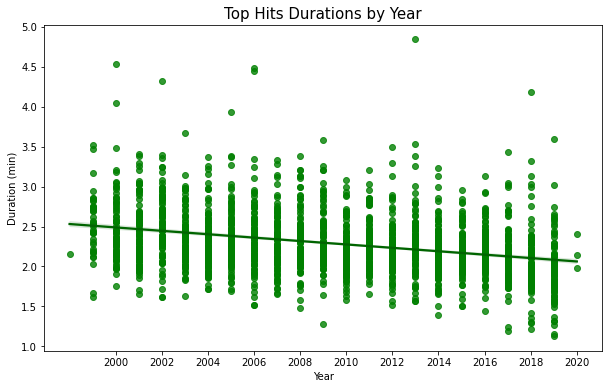

In [204]:
#Top hits duration by year

plt.rcParams["figure.figsize"] = (10,6)
ax = sns.regplot(x="year", y="duration_min", scatter_kws={"color": "green"}, line_kws={"color": "darkgreen"}, data=df_20.toPandas())
ax.set_title("Top Hits Durations by Year", fontsize=15)
ax.set_ylabel("Duration (min)")
ax.set_xlabel("Year")
ax.set_xticks(np.arange(2000, 2021, 2))

### D. How did the number of songs relate to the popularity

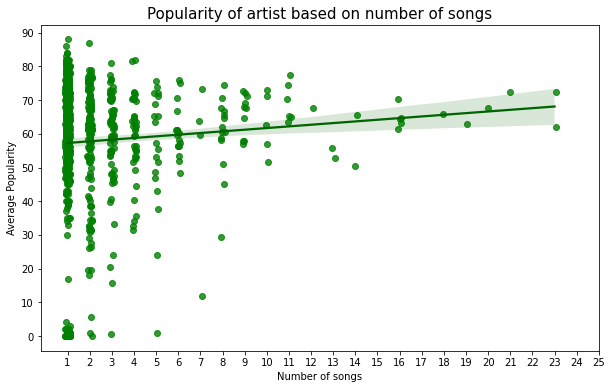

In [205]:
#Regression plot popularity vs songs
plt.rcParams["figure.figsize"] = (10,6)
ax = sns.regplot(y="avg(popularity)", x="count", data=songspopbyartist_df.toPandas(),scatter_kws={"color": "green"}, line_kws={"color": "darkgreen"}, x_jitter=0.1)
ax.set_title("Popularity of artist based on number of songs", fontsize=15)
ax.set_xlabel("Number of songs")
ax.set_xticks(np.arange(1, 26, 1))
ax.set_ylabel("Average Popularity")
ax.set_yticks(np.arange(0, 100, 10))

### E. Based on music feeatures what clusters can we find? 

In [206]:
from pyspark.ml.feature import VectorAssembler

vector_col = "vector_features"

assembler = VectorAssembler(inputCols=['acousticness',
 'danceability',
 'duration_min',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'valence'], outputCol=vector_col)

In [207]:
df_cleaned_vectorized = assembler.transform(df_20)
df_cleaned_vectorized .limit(5).toPandas()

artist                          song  duration_ms  explicit  year  \
0        Vengaboys                  Shalala Lala       214819     False  2000   
1  Destiny's Child      Independent Women, Pt. 1       221133     False  2001   
2           Juanes               La Camisa Negra       216706     False  2004   
3   Arctic Monkeys        When The Sun Goes Down       202133      True  2006   
4            Kesha  Blah Blah Blah (feat. 3OH!3)       172053      True  2010   

   popularity  danceability  energy  key  loudness  mode  speechiness  \
0          58         0.751   0.901    2    -5.802     1       0.0328   
1          65         0.730   0.602    6    -3.782     0       0.2060   
2          70         0.751   0.731    6    -4.419     0       0.0308   
3          72         0.348   0.875   11    -4.758     0       0.1990   
4          61         0.752   0.836   10    -3.173     1       0.1150   

   acousticness  instrumentalness  liveness  valence    tempo  \
0        0.0504          0.003080    0.0395    0.973  124.017   
1        0.3620          0.000004    0.1690    0.927   97.954   
2        0.0838          0.000000    0.0556    0.973   97.007   
3        0.0341          0.000000    0.1170    0.407  169.152   
4        0.0843          0.000425    0.4240    0.519  120.003   

                   genre  duration_min  \
0                    pop       2.14819   
1               pop, R&B       2.21133   
2             pop, latin       2.16706   
3                   rock       2.02133   
4  pop, Dance/Electronic       1.72053   

                                                                              vector_features  
0  [0.0504, 0.751, 2.14819, 0.901, 0.00308, 2.0, 0.0395, -5.802, 1.0, 0.0328, 124.017, 0.973]  
1      [0.362, 0.73, 2.21133, 0.602, 3.69e-06, 6.0, 0.169, -3.782, 0.0, 0.206, 97.954, 0.927]  
2       [0.0838, 0.751, 2.16706, 0.731, 0.0, 6.0, 0.0556, -4.419, 0.0, 0.0308, 97.007, 0.973]  
3       [0.0341, 0.348, 2.02133, 0.875, 0.0, 11.0, 0.117, -4.758, 0.0, 0.199, 169.152, 0.407]  
4  [0.0843, 0.752, 1.72053, 0.836, 0.000425, 10.0, 0.424, -3.173, 1.0, 0.115, 120.003, 0.519]

In [208]:
from pyspark.ml.feature import StandardScaler

standard_scaler = StandardScaler(inputCol="vector_features",outputCol="scaled")

In [209]:
df_cleaned_vectorized_scaled = standard_scaler.fit(df_cleaned_vectorized).transform(df_cleaned_vectorized)

In [210]:
df_cleaned_vectorized_scaled.limit(5).toPandas()

artist                          song  duration_ms  explicit  year  \
0        Vengaboys                  Shalala Lala       214819     False  2000   
1  Destiny's Child      Independent Women, Pt. 1       221133     False  2001   
2           Juanes               La Camisa Negra       216706     False  2004   
3   Arctic Monkeys        When The Sun Goes Down       202133      True  2006   
4            Kesha  Blah Blah Blah (feat. 3OH!3)       172053      True  2010   

   popularity  danceability  energy  key  loudness  ...  speechiness  \
0          58         0.751   0.901    2    -5.802  ...       0.0328   
1          65         0.730   0.602    6    -3.782  ...       0.2060   
2          70         0.751   0.731    6    -4.419  ...       0.0308   
3          72         0.348   0.875   11    -4.758  ...       0.1990   
4          61         0.752   0.836   10    -3.173  ...       0.1150   

   acousticness  instrumentalness  liveness  valence    tempo  \
0        0.0504          0.003080    0.0395    0.973  124.017   
1        0.3620          0.000004    0.1690    0.927   97.954   
2        0.0838          0.000000    0.0556    0.973   97.007   
3        0.0341          0.000000    0.1170    0.407  169.152   
4        0.0843          0.000425    0.4240    0.519  120.003   

                   genre duration_min  \
0                    pop      2.14819   
1               pop, R&B      2.21133   
2             pop, latin      2.16706   
3                   rock      2.02133   
4  pop, Dance/Electronic      1.72053   

                                                                              vector_features  \
0  [0.0504, 0.751, 2.14819, 0.901, 0.00308, 2.0, 0.0395, -5.802, 1.0, 0.0328, 124.017, 0.973]   
1      [0.362, 0.73, 2.21133, 0.602, 3.69e-06, 6.0, 0.169, -3.782, 0.0, 0.206, 97.954, 0.927]   
2       [0.0838, 0.751, 2.16706, 0.731, 0.0, 6.0, 0.0556, -4.419, 0.0, 0.0308, 97.007, 0.973]   
3       [0.0341, 0.348, 2.02133, 0.875, 0.0, 11.0, 0.117, -4.758, 0.0, 0.199, 169.152, 0.407]   
4  [0.0843, 0.752, 1.72053, 0.836, 0.000425, 10.0, 0.424, -3.173, 1.0, 0.115, 120.003, 0.519]   

                                                                                                                                                                                                                                           scaled  
0      [0.2920320082540092, 5.34107960153238, 5.473123973372834, 5.893834394768591, 0.03485291662037377, 0.5532090438536779, 0.2803216866998713, -2.99234050870902, 2.0109531058326473, 0.3411413165997008, 4.594843259483186, 4.405797356715408]  
1                [2.097531487856177, 5.191728507481542, 5.633991051088846, 3.9379448453392802, 4.175560465233091e-05, 1.6596271315610336, 1.199351013981728, -1.9505397800650663, 0.0, 2.1425338786444623, 3.6292062913908256, 4.197506834198544]  
2                                   [0.48556115658107085, 5.34107960153238, 5.52120065624425, 4.781790169340555, 0.0, 1.6596271315610336, 0.3945793868484264, -2.279068029642392, 0.0, 0.3203400168070361, 3.5941198389953435, 4.405797356715408]  
3                                [0.19758514844170064, 2.4749609871281866, 5.1499121032579565, 5.723757042644303, 0.0, 3.0426497411952282, 0.8303199327565809, -2.4539048845979865, 0.0, 2.069729329370136, 6.267099889757855, 1.842918318790515]  
4  [0.48845829952009867, 5.348191558391944, 4.383538695323581, 5.468641014457871, 0.004809249858330796, 2.7660452192683893, 3.009022662297353, -1.6364523326669633, 2.0109531058326473, 1.1960747380782193, 4.446124125464741, 2.350060460570706]  

[5 rows x 21 columns]

In [211]:
df_cleaned_vectorized_scaled

DataFrame[artist: string, song: string, duration_ms: int, explicit: boolean, year: int, popularity: int, danceability: double, energy: double, key: int, loudness: double, mode: int, speechiness: double, acousticness: double, instrumentalness: double, liveness: double, valence: double, tempo: double, genre: string, duration_min: double, vector_features: vector, scaled: vector]

#### Principal Component Analysis

In [212]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="scaled", outputCol="pca_features")
df_cleaned_vectorized_PCA = pca.fit(df_cleaned_vectorized_scaled).transform(df_cleaned_vectorized_scaled)
df_cleaned_vectorized_PCA.limit(5).toPandas()

artist                          song  duration_ms  explicit  year  \
0        Vengaboys                  Shalala Lala       214819     False  2000   
1  Destiny's Child      Independent Women, Pt. 1       221133     False  2001   
2           Juanes               La Camisa Negra       216706     False  2004   
3   Arctic Monkeys        When The Sun Goes Down       202133      True  2006   
4            Kesha  Blah Blah Blah (feat. 3OH!3)       172053      True  2010   

   popularity  danceability  energy  key  loudness  ...  acousticness  \
0          58         0.751   0.901    2    -5.802  ...        0.0504   
1          65         0.730   0.602    6    -3.782  ...        0.3620   
2          70         0.751   0.731    6    -4.419  ...        0.0838   
3          72         0.348   0.875   11    -4.758  ...        0.0341   
4          61         0.752   0.836   10    -3.173  ...        0.0843   

   instrumentalness  liveness  valence    tempo                  genre  \
0          0.003080    0.0395    0.973  124.017                    pop   
1          0.000004    0.1690    0.927   97.954               pop, R&B   
2          0.000000    0.0556    0.973   97.007             pop, latin   
3          0.000000    0.1170    0.407  169.152                   rock   
4          0.000425    0.4240    0.519  120.003  pop, Dance/Electronic   

   duration_min  \
0       2.14819   
1       2.21133   
2       2.16706   
3       2.02133   
4       1.72053   

                                                                              vector_features  \
0  [0.0504, 0.751, 2.14819, 0.901, 0.00308, 2.0, 0.0395, -5.802, 1.0, 0.0328, 124.017, 0.973]   
1      [0.362, 0.73, 2.21133, 0.602, 3.69e-06, 6.0, 0.169, -3.782, 0.0, 0.206, 97.954, 0.927]   
2       [0.0838, 0.751, 2.16706, 0.731, 0.0, 6.0, 0.0556, -4.419, 0.0, 0.0308, 97.007, 0.973]   
3       [0.0341, 0.348, 2.02133, 0.875, 0.0, 11.0, 0.117, -4.758, 0.0, 0.199, 169.152, 0.407]   
4  [0.0843, 0.752, 1.72053, 0.836, 0.000425, 10.0, 0.424, -3.173, 1.0, 0.115, 120.003, 0.519]   

                                                                                                                                                                                                                                           scaled  \
0      [0.2920320082540092, 5.34107960153238, 5.473123973372834, 5.893834394768591, 0.03485291662037377, 0.5532090438536779, 0.2803216866998713, -2.99234050870902, 2.0109531058326473, 0.3411413165997008, 4.594843259483186, 4.405797356715408]   
1                [2.097531487856177, 5.191728507481542, 5.633991051088846, 3.9379448453392802, 4.175560465233091e-05, 1.6596271315610336, 1.199351013981728, -1.9505397800650663, 0.0, 2.1425338786444623, 3.6292062913908256, 4.197506834198544]   
2                                   [0.48556115658107085, 5.34107960153238, 5.52120065624425, 4.781790169340555, 0.0, 1.6596271315610336, 0.3945793868484264, -2.279068029642392, 0.0, 0.3203400168070361, 3.5941198389953435, 4.405797356715408]   
3                                [0.19758514844170064, 2.4749609871281866, 5.1499121032579565, 5.723757042644303, 0.0, 3.0426497411952282, 0.8303199327565809, -2.4539048845979865, 0.0, 2.069729329370136, 6.267099889757855, 1.842918318790515]   
4  [0.48845829952009867, 5.348191558391944, 4.383538695323581, 5.468641014457871, 0.004809249858330796, 2.7660452192683893, 3.009022662297353, -1.6364523326669633, 2.0109531058326473, 1.1960747380782193, 4.446124125464741, 2.350060460570706]   

                               pca_features  
0  [3.3667273964590843, 2.9850257454901676]  
1     [1.968284014865617, 4.06987363366867]  
2  [2.9971878855274805, 3.9869433722408814]  
3   [3.055065395010965, 0.4219094375430757]  
4   [3.600134378670853, 1.9852191003072925]  

[5 rows x 22 columns]

In [213]:
classification_data = df_cleaned_vectorized_PCA.select(["pca_features","vector_features","popularity","scaled"])

In [214]:
(train_df, test_df) = classification_data.randomSplit([0.8,0.2],seed=14)

In [215]:
print(f"Train set length: {train_df.count()} records")
print(f"Test set length: {test_df.count()} records")

Train set length: 1537 records


Test set length: 404 records


In [216]:
train_df.show(5)

+--------------------+--------------------+----------+--------------------+
|        pca_features|     vector_features|popularity|              scaled|
+--------------------+--------------------+----------+--------------------+
|[-6.3689174504165...|[0.559,0.581,3.00...|        71|[3.23900580583315...|
|[-6.0649226748664...|[0.976,0.345,1.89...|        65|[5.6552230169824,...|
|[-4.8814456784076...|[0.841,0.418,2.18...|        69|[4.87299442344487...|
|[-4.6370972176480...|[0.953,0.432,2.58...|        67|[5.52195444178711...|
|[-4.1327991651919...|[0.516,0.534,1.97...|        60|[2.98985151307676...|
+--------------------+--------------------+----------+--------------------+
only showing top 5 rows



In [217]:
#working with differnent k in range from 1 to 9 

from pyspark.ml.clustering import KMeans



kmeans2 = KMeans(k=2, seed=221, maxIter=20, featuresCol="pca_features")
kmeans3 = KMeans(k=3, seed=221, maxIter=20, featuresCol="pca_features")
kmeans4 = KMeans(k=4, seed=221, maxIter=20, featuresCol="pca_features")
kmeans5 = KMeans(k=5, seed=221, maxIter=20, featuresCol="pca_features")
kmeans6 = KMeans(k=6, seed=221, maxIter=20, featuresCol="pca_features")
kmeans7 = KMeans(k=7, seed=221, maxIter=20, featuresCol="pca_features")
kmeans8 = KMeans(k=8, seed=221, maxIter=20, featuresCol="pca_features")
kmeans9 = KMeans(k=9, seed=221, maxIter=20, featuresCol="pca_features")



model2 = kmeans2.fit(df_cleaned_vectorized_PCA)
model3 = kmeans3.fit(df_cleaned_vectorized_PCA)
model4 = kmeans4.fit(df_cleaned_vectorized_PCA)
model5 = kmeans5.fit(df_cleaned_vectorized_PCA)
model6 = kmeans6.fit(df_cleaned_vectorized_PCA)
model7 = kmeans7.fit(df_cleaned_vectorized_PCA)
model8 = kmeans8.fit(df_cleaned_vectorized_PCA)
model9 = kmeans9.fit(df_cleaned_vectorized_PCA)

In [218]:
print("This is the cluster size for k=2",model2.summary.clusterSizes)
print("This is the cluster size for k=3",model3.summary.clusterSizes)
print("This is the cluster size for k=4",model4.summary.clusterSizes)
print("This is the cluster size for k=5",model5.summary.clusterSizes)
print("This is the cluster size for k=6",model6.summary.clusterSizes)
print("This is the cluster size for k=7",model7.summary.clusterSizes)
print("This is the cluster size for k=8",model8.summary.clusterSizes)
print("This is the cluster size for k=9",model9.summary.clusterSizes)

This is the cluster size for k=2 [631, 1310]
This is the cluster size for k=3 [425, 876, 640]
This is the cluster size for k=4 [504, 582, 634, 221]
This is the cluster size for k=5 [349, 361, 160, 620, 451]
This is the cluster size for k=6 [430, 445, 239, 303, 132, 392]
This is the cluster size for k=7 [421, 369, 61, 249, 289, 337, 215]
This is the cluster size for k=8 [185, 283, 243, 419, 232, 353, 166, 60]
This is the cluster size for k=9 [279, 136, 200, 175, 277, 289, 322, 63, 200]


In [219]:
# Use the model to transform the DataFrame by adding cluster predictions
predictions2 = model2.transform(df_cleaned_vectorized_PCA)
predictions3 = model3.transform(df_cleaned_vectorized_PCA)
predictions4 = model4.transform(df_cleaned_vectorized_PCA)
predictions5 = model5.transform(df_cleaned_vectorized_PCA)
predictions6 = model6.transform(df_cleaned_vectorized_PCA)
predictions7 = model7.transform(df_cleaned_vectorized_PCA)
predictions8 = model8.transform(df_cleaned_vectorized_PCA)
predictions9 = model9.transform(df_cleaned_vectorized_PCA)

In [220]:
predictions3.limit(5).toPandas()

artist                          song  duration_ms  explicit  year  \
0        Vengaboys                  Shalala Lala       214819     False  2000   
1  Destiny's Child      Independent Women, Pt. 1       221133     False  2001   
2           Juanes               La Camisa Negra       216706     False  2004   
3   Arctic Monkeys        When The Sun Goes Down       202133      True  2006   
4            Kesha  Blah Blah Blah (feat. 3OH!3)       172053      True  2010   

   popularity  danceability  energy  key  loudness  ...  instrumentalness  \
0          58         0.751   0.901    2    -5.802  ...          0.003080   
1          65         0.730   0.602    6    -3.782  ...          0.000004   
2          70         0.751   0.731    6    -4.419  ...          0.000000   
3          72         0.348   0.875   11    -4.758  ...          0.000000   
4          61         0.752   0.836   10    -3.173  ...          0.000425   

   liveness  valence    tempo                  genre  duration_min  \
0    0.0395    0.973  124.017                    pop       2.14819   
1    0.1690    0.927   97.954               pop, R&B       2.21133   
2    0.0556    0.973   97.007             pop, latin       2.16706   
3    0.1170    0.407  169.152                   rock       2.02133   
4    0.4240    0.519  120.003  pop, Dance/Electronic       1.72053   

                                                                              vector_features  \
0  [0.0504, 0.751, 2.14819, 0.901, 0.00308, 2.0, 0.0395, -5.802, 1.0, 0.0328, 124.017, 0.973]   
1      [0.362, 0.73, 2.21133, 0.602, 3.69e-06, 6.0, 0.169, -3.782, 0.0, 0.206, 97.954, 0.927]   
2       [0.0838, 0.751, 2.16706, 0.731, 0.0, 6.0, 0.0556, -4.419, 0.0, 0.0308, 97.007, 0.973]   
3       [0.0341, 0.348, 2.02133, 0.875, 0.0, 11.0, 0.117, -4.758, 0.0, 0.199, 169.152, 0.407]   
4  [0.0843, 0.752, 1.72053, 0.836, 0.000425, 10.0, 0.424, -3.173, 1.0, 0.115, 120.003, 0.519]   

                                                                                                                                                                                                                                           scaled  \
0      [0.2920320082540092, 5.34107960153238, 5.473123973372834, 5.893834394768591, 0.03485291662037377, 0.5532090438536779, 0.2803216866998713, -2.99234050870902, 2.0109531058326473, 0.3411413165997008, 4.594843259483186, 4.405797356715408]   
1                [2.097531487856177, 5.191728507481542, 5.633991051088846, 3.9379448453392802, 4.175560465233091e-05, 1.6596271315610336, 1.199351013981728, -1.9505397800650663, 0.0, 2.1425338786444623, 3.6292062913908256, 4.197506834198544]   
2                                   [0.48556115658107085, 5.34107960153238, 5.52120065624425, 4.781790169340555, 0.0, 1.6596271315610336, 0.3945793868484264, -2.279068029642392, 0.0, 0.3203400168070361, 3.5941198389953435, 4.405797356715408]   
3                                [0.19758514844170064, 2.4749609871281866, 5.1499121032579565, 5.723757042644303, 0.0, 3.0426497411952282, 0.8303199327565809, -2.4539048845979865, 0.0, 2.069729329370136, 6.267099889757855, 1.842918318790515]   
4  [0.48845829952009867, 5.348191558391944, 4.383538695323581, 5.468641014457871, 0.004809249858330796, 2.7660452192683893, 3.009022662297353, -1.6364523326669633, 2.0109531058326473, 1.1960747380782193, 4.446124125464741, 2.350060460570706]   

                               pca_features prediction  
0  [3.3667273964590843, 2.9850257454901676]          1  
1     [1.968284014865617, 4.06987363366867]          1  
2  [2.9971878855274805, 3.9869433722408814]          1  
3   [3.055065395010965, 0.4219094375430757]          2  
4   [3.600134378670853, 1.9852191003072925]          1  

[5 rows x 23 columns]

In [221]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='pca_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,9):
    
    KMeans_algo=KMeans(featuresCol='pca_features', k=i)
    
    KMeans_fit=KMeans_algo.fit(df_cleaned_vectorized_PCA)
    
    output=KMeans_fit.transform(df_cleaned_vectorized_PCA)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score for",i, "amount of clusters is:",score)

Silhouette Score for 2 amount of clusters is: 0.5266554842273122


Silhouette Score for 3 amount of clusters is: 0.5077584002032729


Silhouette Score for 4 amount of clusters is: 0.4884854634538829


Silhouette Score for 5 amount of clusters is: 0.4757565592907476


Silhouette Score for 6 amount of clusters is: 0.46226500104630786


Silhouette Score for 7 amount of clusters is: 0.4726088035936482


Silhouette Score for 8 amount of clusters is: 0.47869950760421115


Text(0, 0.5, 'cost')

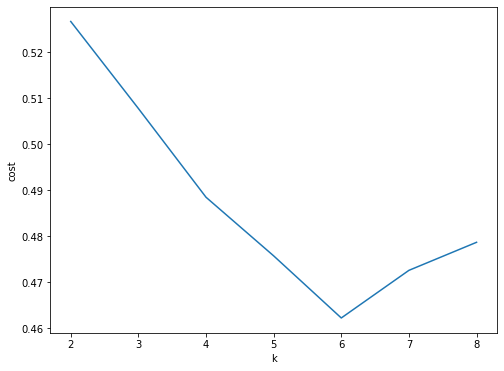

In [222]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,9),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("cost")

In [223]:
# pip install plotly

In [224]:
import numpy as np
import pandas as pd 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

df_kmeans = predictions3.select((vector_to_array(col('pca_features'))[0]).alias('x'),
                        (vector_to_array(col('pca_features'))[1]).alias('y'),
                         col('prediction').alias('label')).toPandas()

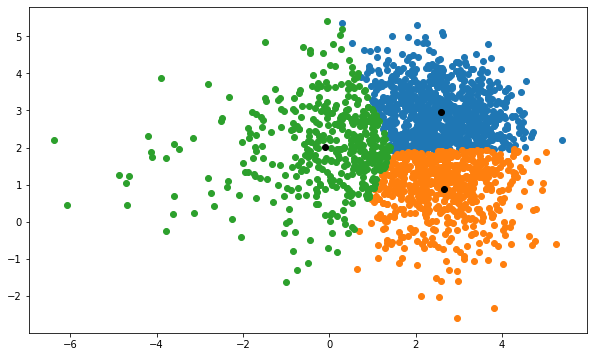

In [226]:
clusters = df_kmeans['label'].unique()

centroids = model3.clusterCenters()
  
fig = plt.figure()
ax = fig.add_subplot(111)

for i in list(clusters):
    t = df_kmeans.loc[df_kmeans['label']==i]
    ax.scatter(x=t['x'],y=t['y'],label=i)

for c in centroids:    
    ax.scatter(x=c[0],y=c[1],c='black')
       
plt.show()

### F. Can we find a model to predict popularity of a song based on music attributes? 

In [227]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
rf = RandomForestClassifier(featuresCol="pca_features",labelCol="popularity",maxDepth = 10)
rfModel = rf.fit(train_df)
rf.predictions = rfModel.transform(test_df)

In [228]:
rf.predictions.show()

+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----------+
|        pca_features|     vector_features|popularity|              scaled|       rawPrediction|         probability|prediction|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----------+
|[-4.7144510752398...|[0.856,0.562,2.52...|        55|[4.95990871161571...|[0.44085191835191...|[0.02204259591759...|       4.0|
|[-4.6797703447567...|[0.966,0.398,2.30...|        63|[5.59728015820184...|[1.67222138222138...|[0.08361106911106...|      65.0|
|[-4.1950155863218...|[0.687,0.492,2.51...|        77|[3.98067439822429...|[4.00928723745102...|[0.20046436187255...|       0.0|
|[-3.7768076732673...|[0.82,0.597,1.975...|        60|[4.75131442000570...|[3.14633204917687...|[0.15731660245884...|      84.0|
|[-2.7474406812618...|[0.922,0.422,2.69...|        84|[5.34233157956739...|[0.92956986706986...|[

In [229]:
rfModel.featureImportances

SparseVector(2, {0: 0.5175, 1: 0.4825})

In [230]:
evaluator = MulticlassClassificationEvaluator(labelCol="popularity", predictionCol="prediction")
accuracy = evaluator.evaluate(rf.predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.021811760766533527
Test Error = 0.9781882392334664


In [231]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'vector_features', labelCol='popularity', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [3.8426372970611853,0.0,1.4127757478773477,-0.7144728208458003,-5.702286665507793,0.017291922734525393,0.0,0.2372662885227762,-0.21239023839455562,5.6245686435195195,0.01147027819681535,0.0]
Intercept: 55.78015848853321


In [232]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 21.739897
r2: 0.006112
